In [1]:
include("astrobee_se3_script.jl")
using Plots
using JLD2, FileIO
using HDF5
using Keras
using Polynomials
using Statistics
using StatsPlots
using StatsBase

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /home/somrita/.julia/packages/CUDAdrv/3EzC1/src/CUDAdrv.jl:69


# Helper functions

## Main GuSTO function

In [2]:
function solve_gusto(model, N, MAX_ITERATIONS_NB, verbose = true, Xp = [], Up = [])
    
    if (Xp == [] && Up == [])
        Xp,Up = initialize_trajectory(model, N)
    elseif Up == []
        println("GuSTO X has been warm-started.")
        Up = zeros(model.u_dim, N-1)
    else
        if verbose
            println("GuSTO has been warm-started.")
        end
    end
    X, U  = copy(Xp)  , copy(Up) 

    SCPproblem = GuSTOProblem(model, N, Xp, Up)

    x_dim, u_dim = model.x_dim, model.u_dim

    Delta0, omega0, omegamax, 
        epsilon, rho0, rho1, 
        beta_succ, beta_fail, gamma_fail, 
        convergence_threshold = get_initial_gusto_parameters(model)

    Delta = Delta0
    omega = omega0

    X_all, U_all = [], []
    push!(X_all, copy(X))
    push!(U_all, copy(U))

    B_success = false
    it = 0

    while it<MAX_ITERATIONS_NB && 
            !(it!=0 && it!=1 && it!=2 && it!=3 && B_success && 
                convergence_metric(model,X,U,Xp,Up)<convergence_threshold) &&
            omega<omegamax
        if verbose
            println("-----------")
            println("Iteration $it")
            println("metric=$(convergence_metric(model,X,U,Xp,Up))")
            println("-----------")
        end

        Xp = copy(X)
        Up = copy(U)

        model.f, model.A, model.B = compute_dynamics(model, Xp, Up)

        reset_problem(SCPproblem, model)
        set_parameters(SCPproblem, model, Xp, Up, omega, Delta)
        define_cost(SCPproblem, model)
        define_constraints(SCPproblem, model)

        JuMP.optimize!(SCPproblem.solver_model)    

        # get solution
        X_sol = JuMP.value.(SCPproblem.X)
        U_sol = JuMP.value.(SCPproblem.U)

        # -----------
        # GuSTO Logic
        if it > 3
            if is_in_trust_region(model, X_sol, U_sol, Xp, Up, Delta)
                rho = accuracy_ratio(SCPproblem, model, X_sol, U_sol, Xp, Up)

                if rho > rho1
                    if verbose
                        println("Reject solution.")
                    end
                    Delta = beta_fail * Delta
                    omega     = omega
                    B_success = false

                else
                    if verbose
                        println("Accept solution.")
                    end
                    X = copy(X_sol)
                    U = copy(U_sol)
                    B_success = true
                    if rho < rho0
                        Delta = min(beta_succ*Delta, Delta0)
                    else
                        Delta = Delta
                    end
                    if satisfies_state_inequality_constraints(SCPproblem, model, X_sol, U_sol, Xp, Up, Delta)
                        omega = omega0
                    else
                        if verbose
                            println("Solution does not satisfy state constraints, increasing omega.")
                        end
                        omega = gamma_fail * omega
                        B_success = false
                    end
                end
            else
                if verbose
                    println("Reject solution (Outside trust region)")
                end
                Delta = Delta
                omega     = gamma_fail * omega
                B_success = false
            end

        else # always accept first solution
            X = copy(X_sol)
            U = copy(U_sol)
        end


        # -----------

        push!(X_all, copy(X))
        push!(U_all, copy(U))


        it += 1

        diff_with_prev = norm(copy(X) - copy(Xp), Inf)
        if verbose
            println("x(k) - x(k-1) = $diff_with_prev")
            println("Parameters:")
            println("omega=$omega")
            println("delta=$Delta")
        end
    end
    curr_conv_metric = convergence_metric(model,X,U,Xp,Up)
    if (B_success && 
                curr_conv_metric<convergence_threshold)
        if verbose
            println("Converged")
        end
        isConverged = true
    else
        if verbose
            println("Not converged. Metric =$curr_conv_metric")
        end
        isConverged = false
    end
    return isConverged, it, X_all, U_all
end

solve_gusto (generic function with 4 methods)

## Function to check if inside obstacle

In [3]:
function isInsideObstacle(x, model)
    isInside = false
    for obs in model.obstacles
        center = obs[1]
        radius = obs[2]
        if norm(x[1:3] - center) < radius
            isInside = true
            return isInside
        end
    end
    for obs in model.poly_obstacles
        center = obs.c
        dx = obs.dx
        dy = obs.dy
        dz = obs.dz
        x_max = center[1]+dx
        y_max = center[2]+dy
        z_max = center[3]+dz
        x_min = center[1]-dx
        y_min = center[2]-dy
        z_min = center[3]-dz
        if (x[1]<= x_max && x[1] >= x_min && 
            x[2]<= y_max && x[2] >= y_min &&
            x[3]<= z_max && x[3] >= z_min)
            isInside = true
            return isInside
        end
    end
    return isInside
end

isInsideObstacle (generic function with 1 method)

## Plotting functions

In [4]:
function plot_env_solution(model, X_all)
    N = length(X_all)

    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter ==1 
            color = :darkblue
            plot!(fig, X[1,:], X[2,:], line=(5, :dash); c=color, lab = "Initial guess")
        elseif iter == length(X_all)
            color = :green
            plot!(fig, X[1,:], X[2,:], line=(5, :dash), c=color, lab = "Final solution")
        else
            color = :blue
            plot!(fig, X[1,:], X[2,:]; c=color, lab = "")
        end
        
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black,
                legend = false, fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[1],model.x_max[1]))
    ylims!((model.x_min[2],model.x_max[2]))
    plot!(leg = true)
    return fig
end

plot_env_solution (generic function with 1 method)

In [5]:
function plot_env_and_trajs(model, X_all, labls = :None)
    N = length(X_all)
    if labls == :None
        labls = fill("",(size(X_all,1),1))
    end
    
    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    for iter = 1:length(X_all)
        X = X_all[iter]
        plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter])
    end

    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black,
                legend = false, fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(leg = true)
    return fig
end

plot_env_and_trajs (generic function with 2 methods)

In [6]:
function plot_three_comp_3D(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
    labls = ["GuSTO solution ($iter1 iterations, $time1 seconds)", "NN prediction   ($time2 seconds)", "GuSTO warm-started ($iter3 iterations, $time3 seconds)"]
    idx = [1,2]
    local fig
#     fig = plot()
    fig = plot(framestyle = :box)
    


    for obs_i = 1
        (c1,c2,c3)  =  model.poly_obstacles[obs_i].c
        dx = model.poly_obstacles[obs_i].dx
        dy = model.poly_obstacles[obs_i].dy
        dz = model.poly_obstacles[obs_i].dz
        
        xmin = c1 - dx
        xmax = c1 + dx
        ymin = c2 - dy
        ymax = c2 + dy
        zmin = c3 - dz
        zmax = c3 + dz
        zmin = 0.2
        zmax = 0.8

        a = (zmax-zmin)/0.002
        b = zmax-0.003*a

        # top and bottom surfaces
        x = range(xmin, stop = xmax, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        f(x,y) = zmax
        g(x,y) = zmin
        plot!(x,y,f, seriestype = :surface, fillalpha = 1.0)
        plot!(x,y,g, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        

        dx = range(xmin + 0.001, stop = xmin + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        h(x,y) = a*(x-xmin) +b
        plot!(dx,y,h, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymax + 0.001, stop = ymax + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        m(x,y) = a*(y-ymax)+b
        plot!(x,dy,m, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        
        dx = range(xmax + 0.001, stop = xmax + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        k(x,y) = a*(x-xmax) +b
        plot!(dx,y,k, seriestype = :surface, fillalpha = 1.0)

        
    end
    
    for obs_i = 2
        (c1,c2,c3)  =  model.poly_obstacles[obs_i].c
        dx = model.poly_obstacles[obs_i].dx
        dy = model.poly_obstacles[obs_i].dy
        dz = model.poly_obstacles[obs_i].dz
        
        xmin = c1 - dx
        xmax = c1 + dx
        ymin = c2 - dy
        ymax = c2 + dy
        zmin = c3 - dz
        zmax = c3 + dz
        zmin = 0.2
        zmax = 0.8

        a = (zmax-zmin)/0.002
        b = zmax-0.003*a

        # top and bottom surfaces
        x = range(xmin, stop = xmax, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        f(x,y) = zmax
        g(x,y) = zmin
        plot!(x,y,f, seriestype = :surface, fillalpha = 1.0)
        plot!(x,y,g, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        

        dx = range(xmin + 0.001, stop = xmin + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        h(x,y) = a*(x-xmin) +b
        plot!(dx,y,h, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymax + 0.001, stop = ymax + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        m(x,y) = a*(y-ymax)+b
        plot!(x,dy,m, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        
        dx = range(xmax + 0.001, stop = xmax + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        k(x,y) = a*(x-xmax) +b
        plot!(dx,y,k, seriestype = :surface, fillalpha = 1.0)

        
    end
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 6, markershape = :octagon,  markerstrokealpha = 0.5, lab = labls[iter], color = iter )
        elseif iter ==2 
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 4, lab = labls[iter], color = iter )
        else
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 4, markeralpha=0.5,  markerstrokealpha = 0.5, lab = labls[iter], color = iter )
        end       
    end
    
    st_pt = X_all[1][:,1]
    scatter!([st_pt[1]], [st_pt[2]],[st_pt[3]], shape = :circle, markersize = 6, color = :white, lab = "Start point")
    end_pt = X_all[1][:,end]
    scatter!([end_pt[1]], [end_pt[2]],[end_pt[3]], shape = :star, markersize = 8, color = :white, lab = "Goal point")

    xlims!((model.x_min[1],model.x_max[1]))
    ylims!((model.x_min[2],model.x_max[2]))
    plot!(zlim = (model.x_min[3]+0.3,model.x_max[3]-0.2), zaxis = "Z")
    plot!(leg =  :best, legfontsize = 10)
    xlabel!("X")
    ylabel!("Y")
    plot!(camera=(120,30), colorbar = :false)
    plot!(size=(700,700,700))
    return fig
end

plot_three_comp_3D (generic function with 7 methods)

In [7]:
function plot_three_comp(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
    labls = ["GuSTO solution ($iter1 iterations, $time1 seconds)", "NN prediction   ($time2 seconds)", "GuSTO warm-started ($iter3 iterations, $time3 seconds)"]
    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    
    
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 1)
        elseif iter == 2
            r = plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 2)
#             @show r.color
        else
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(6, :dashdot), linealpha = 0.7, lab = labls[iter], color = 3)
        end        
    end
    
    st_pt = X_all[1][idx[1]:idx[2],1]
    scatter!([st_pt[1]], [st_pt[2]], shape = :circle, markersize = 6, color = :black, lab = "")
    end_pt = X_all[1][idx[1]:idx[2],end]
    scatter!([end_pt[1]], [end_pt[2]], shape = :star, markersize = 8, color = :black, lab = "")
    annotate!([(st_pt[1]-0.5, st_pt[2]+0.4, text("Start", 14, :black, :left)), 
            (end_pt[1]+0.3, end_pt[2]-0.4, text("Goal", 14, :black, :right))])


    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black, linealpha = 0.7,
                fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(leg =  :bottomright)
    return fig
end

plot_three_comp (generic function with 7 methods)

## Reading and writing to files

In [8]:
function getXYValid(filename)
    f = h5open(filename,"r")
    X_valid_norm = read(f["X_valid_norm"])
    Y_valid_norm = read(f["Y_valid_norm"])
    close(f)
    return (X_valid_norm, Y_valid_norm) 
end


getXYValid (generic function with 1 method)

In [9]:
function getDataParamsFromHDF5Combo(filename)
    f = h5open(filename,"r")
    xMin = read(f["xMin"])
    yMin = read(f["yMin"])
    xRange = read(f["xRange"])
    yRange = read(f["yRange"])
    close(f)
    return (xMin, yMin, xRange, yRange) 
end
    

getDataParamsFromHDF5Combo (generic function with 1 method)

In [10]:
function getDataParamsFromHDF5(filename)
    f = h5open(filename,"r")
    xMin_train = read(f["xMin_train"])
    yMin_train = read(f["yMin_train"])
    xRange_train = read(f["xRange_train"])
    yRange_train = read(f["yRange_train"])
    xMin_test = read(f["xMin_test"])
    yMin_test = read(f["yMin_test"])
    xRange_test = read(f["xRange_test"])
    yRange_test = read(f["yRange_test"])
    xMin_valid = read(f["xMin_valid"])
    yMin_valid = read(f["yMin_valid"])
    xRange_valid = read(f["xRange_valid"])
    yRange_valid = read(f["yRange_valid"])
    close(f)
    return (xMin_train, yMin_train, xRange_train, yRange_train, 
    xMin_test, yMin_test, xRange_test, yRange_test, 
    xMin_valid, yMin_valid, xRange_valid, yRange_valid) 
end
    

getDataParamsFromHDF5 (generic function with 1 method)

## NN helper functions

In [11]:
function recoverCoeffsfromNNOutput(NN_output, yMin, yRange)
    output_coeffs = (NN_output.*yRange)+yMin    
    return output_coeffs
end

recoverCoeffsfromNNOutput (generic function with 1 method)

In [12]:
function recoverXUfromCoeffsSingleDim(coeffs, dim)
    N = 50
    tf_guess = 110.
    t_array = range(0,stop=tf_guess,length=N)
    t_minus_one_array = t_array[1:end-1]
    num_coeffs = 5
    x_dim = 13
    u_dim = 6
    
    if dim<=x_dim
        cf_this = coeffs
        this_poly = polyval(Poly(cf_this), t_array)
        traj = this_poly
    else
        cf_this = coeffs
        this_poly = polyval(Poly(cf_this), t_minus_one_array)
        traj = this_poly
    end
    
    return traj
end

recoverXUfromCoeffsSingleDim (generic function with 1 method)

In [13]:
function recoverXUfromCoeffs(coeffs)
    N = 50
    tf_guess = 110.
    t_array = range(0,stop=tf_guess,length=N)
    t_minus_one_array = t_array[1:end-1]
    num_coeffs = 5
    x_dim = 13
    u_dim = 6
    
    X_soln = zeros(x_dim, N)
    U_soln = zeros(u_dim, N-1)
    
    for dim = 1:x_dim
        cf_this = coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
        this_poly = polyval(Poly(cf_this), t_array)
        X_soln[dim, :] = this_poly
    end
    
    for dim = 1:u_dim
        cf_this = coeffs[(x_dim*num_coeffs + (dim-1)*num_coeffs + 1): (x_dim*num_coeffs + dim*num_coeffs)]
        this_poly = polyval(Poly(cf_this), t_minus_one_array)
        U_soln[dim, :] = this_poly
    end
    
    return X_soln, U_soln
end

recoverXUfromCoeffs (generic function with 1 method)

In [14]:
function recoverXUfromNNOutput(NN_output, yMin, yRange)
    outputCoeffs = recoverCoeffsfromNNOutput(NN_output, yMin, yRange)
    X_soln, U_soln = recoverXUfromCoeffs(outputCoeffs)
end

recoverXUfromNNOutput (generic function with 1 method)

In [15]:
function createNNInput(x_init, x_final, xMin, xRange)
    # x_init and x_goal need to be of size 13
    NN_input = hcat([x_init', x_final']...)'
    NN_input = (NN_input-xMin)./xRange
    return NN_input
end

createNNInput (generic function with 1 method)

In [16]:
function getNNStructureCombo(NNDualParams, NNDualJSON, NNDualWeights)
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(NNDualParams)
    NN = Keras.load(NNDualJSON, NNDualWeights)
    return (NN, xMin, yMin, xRange, yRange)  
end

getNNStructureCombo (generic function with 1 method)

In [17]:
function getNNStructure(NNDualParams, NNDualJSON, NNDualWeights)
    (xMin_train, yMin_train, xRange_train, yRange_train, 
    xMin_test, yMin_test, xRange_test, yRange_test, 
    xMin_valid, yMin_valid, xRange_valid, yRange_valid)  = getDataParamsFromHDF5(NNDualParams)
    NN = Keras.load(NNDualJSON, NNDualWeights)
    return (NN, xMin_train, yMin_train, xRange_train, yRange_train, 
    xMin_test, yMin_test, xRange_test, yRange_test, 
    xMin_valid, yMin_valid, xRange_valid, yRange_valid) 
end

getNNStructure (generic function with 1 method)

In [18]:
function getNNPredictionCombo(x_init, x_final, NNDualParams, NNDualJSON, NNDualWeights)
    # x_init and x_goal need to be of size 13
    (NN, xMin, yMin, xRange, yRange) = getNNStructureCombo(NNDualParams, NNDualJSON, NNDualWeights)
    NN_input = zeros(1,26)
    NN_input = createNNInput(x_init, x_final, xMin, xRange)
    NN_output = NN(NN_input)
    X_soln, U_soln = recoverXUfromNNOutput(NN_output, yMin, yRange)
    return (X_soln, U_soln)
end

getNNPredictionCombo (generic function with 1 method)

In [19]:
function getNNPrediction(x_init, x_final, NNDualParams, NNDualJSON, NNDualWeights)
    # x_init and x_goal need to be of size 13
    (NN, xMin_train, yMin_train, xRange_train, yRange_train, 
    xMin_test, yMin_test, xRange_test, yRange_test, 
    xMin_valid, yMin_valid, xRange_valid, yRange_valid) = getNNStructure(NNDualParams, NNDualJSON, NNDualWeights)
    NN_input = zeros(1,26)
    NN_input = createNNInput(x_init, x_final, xMin_train, xRange_train)
    NN_output = NN(NN_input)
    X_soln, U_soln = recoverXUfromNNOutput(NN_output, yMin_train, yRange_train)
    return (X_soln, U_soln)
end

getNNPrediction (generic function with 1 method)

In [20]:
function getNNCoeffsCombo(x_init, x_final, NNDualParams, NNDualJSON, NNDualWeights)
    # x_init and x_goal need to be of size 13
    (NN, xMin, yMin, xRange, yRange) = getNNStructureCombo(NNDualParams, NNDualJSON, NNDualWeights)
    NN_input = zeros(1,26)
    NN_input = createNNInput(x_init, x_final, xMin, xRange)
    NN_output = NN(NN_input)
    outputCoeffs = recoverCoeffsfromNNOutput(NN_output, yMin, yRange)
    return (outputCoeffs)
end

getNNCoeffsCombo (generic function with 1 method)

## Get model on which data was collected and training done

In [21]:
function getModelWithTwoPolyObsOneAtCorner()
    N = 50
    MAX_ITERATIONS_NB = 100

    model = AstrobeeSE3()

    # Set up environment
    model.x_max[1:3] = [10.0; 10.0; 1.0]
    model.x_min[1:3] = [0.0; 0.0; 0.0]

    obstacles = []
    # obs = [[0.0,0.0,0.0], 6.0]
    # push!(obstacles, obs)
    model.obstacles = obstacles

    poly_obstacles = []
    obs = PolygonalObstacle([2.5,2.5,0], [5.0, 5.0, 2.0])
    push!(poly_obstacles, obs)
    obs = PolygonalObstacle([7.0,3.0,0], [1.0, 1.0, 2.0])
    push!(poly_obstacles, obs)
    model.poly_obstacles = poly_obstacles

    model.tf_guess = 110.
    model.convergence_threshold = 2.0
    
    return model
end

getModelWithTwoPolyObsOneAtCorner (generic function with 1 method)

In [22]:
function getModelWithCornerSpheres()
    N = 50
    MAX_ITERATIONS_NB = 100

    model = AstrobeeSE3()

    # Set up environment
    model.x_max[1:3] = [10.0; 10.0; 1.0]
    model.x_min[1:3] = [0.0; 0.0; 0.0]
    model.obstacles = []
    obstacles = []
    obs = [[0.0,0.0,0.0], 6.0]
    push!(obstacles, obs)
    obs = [[5.0,5.0,0.0], 1.3]
    push!(obstacles, obs)
    obs = [[3.0,5.0,0.0], 1.3]
    push!(obstacles, obs)
    obs = [[5.0,3.0,0.0], 1.3]
    push!(obstacles, obs)
    model.obstacles = obstacles

    model.tf_guess = 110.
    model.convergence_threshold = 0.7
    
    return model
end

getModelWithCornerSpheres (generic function with 1 method)

In [23]:
function findTrueGuSTOSolution(x_init, x_final, model = :None, verbose = false, Xinit = [], Uinit = [])
    N = 50
    MAX_ITERATIONS_NB = 200
    
    if model == :None
        println("No model supplied. Using spheres model.")
        model = getModelWithCornerSpheres()
    end
    
    isConverged = false
    X_all = []
    U_all = []
    numIter = 0

    problemNumber = 0

    train_input_collected = Array{Float64}(undef,0,26)
    train_output_collected = Array{Float64}(undef,0,944)

    if isInsideObstacle(x_init, model)
        println("x_init is inside an obstacle. Not valid.")
        return model, isConverged, X_all, U_all
    end
    if isInsideObstacle(x_final, model)
        println("x_final is inside an obstacle. Not valid.")
        return model, isConverged, X_all, U_all
    end
    if norm(x_final[1:3] - x_init[1:3])<1.0
        println("x_init and x_final too close. Not valid.")
        return model, isConverged, X_all, U_all
    end


    model.x_init = x_init
    model.x_final = x_final
    
    if verbose
        println("Starting to solve GuSTO")
    end
    try
        isConverged, numIter, X_all, U_all = solve_gusto(model, N, MAX_ITERATIONS_NB, verbose, Xinit, Uinit)
    catch e
        isConverged = false
        println("$e")
    end
    if verbose
        println("Converged: $isConverged")
    end

    return model, isConverged, numIter, X_all, U_all
end



findTrueGuSTOSolution (generic function with 5 methods)

# Compare GuSTO to NN for all full validation set

## Compare relative error between X_NN and X_poly 

In [41]:
x_dim = 13
u_dim = 6

filename = "PolyComboCoeffsNormalized.jld2"
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
(X_valid_norm, Y_valid_norm)  =getXYValid(filename)
X_valid_norm = X_valid_norm'
Y_valid_norm = Y_valid_norm'
@show size(X_valid_norm)
@show size(Y_valid_norm)

# row = 10
meanError = zeros(size(X_valid_norm,1))
allErrors = zeros(size(X_valid_norm,1), x_dim + u_dim)

# for row in 1:size(X_valid_norm,1)
for row in 1:size(X_valid_norm,1)
    @show row
    # For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
    x_v_norm = X_valid_norm[row,:] # size 26
    # First convert to X_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    x_v = x_v_norm.*xRange + xMin
    x_init = x_v[1:13]
    x_final = x_v[14:26]
#     @show x_init
#     @show x_final
    
    
    # NN prediction time and trajectory
    X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
#     @show size(X_soln_NN)
#     @show size(U_soln_NN)

    # For the Y_valid_norm, these are 95 coefficients
    y_v_norm = Y_valid_norm[row,:] # size 95
    # First convert to Y_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    y_v = y_v_norm.*yRange + yMin
    # Using these, we recover the poly X and poly U
    (X_soln_poly, U_soln_poly)= recoverXUfromCoeffs(y_v)
#     @show size(X_soln_poly)
#     @show size(U_soln_poly)


    totalerror = 0
    for j in 1:x_dim
#         @show norm(X_soln_poly[j,:])
#         @show norm(X_soln_NN[j,:] - X_soln_poly[j,:])
#         totalerror = totalerror + norm(X_soln_NN[i,:] - X_soln_poly[i,:])/norm(X_soln_poly[i,:])
#         totalerror = totalerror + norm(X_soln_NN[j,:] - X_soln_poly[j,:])
        thiserror = 0
        if norm(X_soln_poly[j,:])<1e-1 && norm(X_soln_NN[j,:])<1e-1
            thiserrror = 0
        elseif norm(X_soln_poly[j,:])<1e-1
            @show norm(X_soln_poly[j,:])
            @show norm(X_soln_NN[j,:])
            thiserror = 0
        else
            thiserror = norm(X_soln_NN[j,:] - X_soln_poly[j,:])/norm(X_soln_NN[j,:])
        end
#         @show thiserror
        allErrors[row, j] = thiserror
        totalerror = totalerror + thiserror
    end
#     @show totalerror
    for j in 1:u_dim
#         @show norm(U_soln_poly[j,:])
#             @show norm(U_soln_NN[j,:] - U_soln_poly[j,:])
        thiserror = 0
        if norm(U_soln_poly[j,:])<1e-1 && norm(U_soln_NN[j,:])<1e-1
            thiserror = 0
        elseif norm(U_soln_poly[j,:])<1e-1
            thiserror = 0
            @show norm(U_soln_poly[j,:])
            @show norm(U_soln_NN[j,:])
        else
            thiserror = norm(U_soln_NN[j,:] - U_soln_poly[j,:])/norm(U_soln_NN[j,:])
        end
#         @show thiserror
        allErrors[row, x_dim + j] = thiserror
        totalerror = totalerror + thiserror
            
    end
#     @show totalerror
#     @show totalerror/(x_dim+u_dim)
    meanError[row] = totalerror/(x_dim+u_dim)
#     @show meanError[row]
    
end
@save "relErrorPolyNN.jld2" allErrors
#     gr = plot()
#     plot!(X_soln_poly[1,:],X_soln_poly[2,:], lab="poly")
#     plot!(X_soln_NN[1,:],X_soln_NN[2,:], lab="NN")



size(X_valid_norm) = (1130, 26)
size(Y_valid_norm) = (1130, 95)
row = 1
norm(X_soln_poly[j, :]) = 0.07654571792229761
norm(X_soln_NN[j, :]) = 0.421975864609791
norm(X_soln_poly[j, :]) = 3.4203562988385046e-6
norm(X_soln_NN[j, :]) = 0.24389239217467742
norm(U_soln_poly[j, :]) = 0.014908923752633705
norm(U_soln_NN[j, :]) = 0.10772598303808115
row = 2
norm(X_soln_poly[j, :]) = 9.087653471269652e-7
norm(X_soln_NN[j, :]) = 0.33574686670125914
row = 3
norm(X_soln_poly[j, :]) = 1.338765780366286e-6
norm(X_soln_NN[j, :]) = 0.3374563120905079
row = 4
norm(X_soln_poly[j, :]) = 3.108466773106568e-7
norm(X_soln_NN[j, :]) = 0.2521958176118314
row = 5
norm(X_soln_poly[j, :]) = 1.1428504739606236e-6
norm(X_soln_NN[j, :]) = 0.34082869802786925
row = 6
norm(X_soln_poly[j, :]) = 6.195610934388148e-8
norm(X_soln_NN[j, :]) = 0.34773347441329355
row = 7
norm(X_soln_poly[j, :]) = 3.639944686672753e-7
norm(X_soln_NN[j, :]) = 0.3379065601253608
row = 8
norm(X_soln_poly[j, :]) = 1.5304968912406033e-7
norm(X_so

norm(X_soln_poly[j, :]) = 3.977685797306182e-5
norm(X_soln_NN[j, :]) = 0.30765176045469045
row = 76
norm(X_soln_poly[j, :]) = 3.759670111478334e-7
norm(X_soln_NN[j, :]) = 0.3952824820306927
row = 77
norm(X_soln_poly[j, :]) = 0.002275414279089769
norm(X_soln_NN[j, :]) = 0.3583787360112183
row = 78
norm(X_soln_poly[j, :]) = 6.004380457995917e-6
norm(X_soln_NN[j, :]) = 0.3136565416831283
norm(U_soln_poly[j, :]) = 0.09013526524822421
norm(U_soln_NN[j, :]) = 0.11698921563594805
row = 79
norm(X_soln_poly[j, :]) = 9.728042662855466e-6
norm(X_soln_NN[j, :]) = 0.3465991779718207
row = 80
norm(X_soln_poly[j, :]) = 2.0333974201643505e-6
norm(X_soln_NN[j, :]) = 0.34095259800396194
norm(U_soln_poly[j, :]) = 0.09915465242208571
norm(U_soln_NN[j, :]) = 0.11597327386737982
row = 81
norm(X_soln_poly[j, :]) = 7.433176968894698e-7
norm(X_soln_NN[j, :]) = 0.3431792487830547
row = 82
norm(X_soln_poly[j, :]) = 8.582479572607812e-6
norm(X_soln_NN[j, :]) = 0.34907655072771177
row = 83
norm(X_soln_poly[j, :]) 

norm(X_soln_poly[j, :]) = 6.265544317455761e-7
norm(X_soln_NN[j, :]) = 0.36006504721645805
row = 152
norm(X_soln_poly[j, :]) = 3.397832616272486e-7
norm(X_soln_NN[j, :]) = 0.3489903892250824
row = 153
norm(X_soln_poly[j, :]) = 4.990392160227393e-7
norm(X_soln_NN[j, :]) = 0.3492840564438347
row = 154
norm(X_soln_poly[j, :]) = 5.551811873466359e-7
norm(X_soln_NN[j, :]) = 0.3435222440355112
row = 155
norm(X_soln_poly[j, :]) = 0.07655352587112202
norm(X_soln_NN[j, :]) = 0.10662792811542955
norm(X_soln_poly[j, :]) = 3.916321903087104e-7
norm(X_soln_NN[j, :]) = 0.34893664755124837
row = 156
norm(X_soln_poly[j, :]) = 4.236567863761615e-8
norm(X_soln_NN[j, :]) = 0.3456856212612378
row = 157
norm(X_soln_poly[j, :]) = 5.792291236176084e-6
norm(X_soln_NN[j, :]) = 0.3465595777679968
row = 158
norm(X_soln_poly[j, :]) = 0.00039833162265073954
norm(X_soln_NN[j, :]) = 0.3198243539935777
norm(U_soln_poly[j, :]) = 0.09855355853162348
norm(U_soln_NN[j, :]) = 0.11154987078560427
row = 159
norm(X_soln_poly

norm(X_soln_poly[j, :]) = 7.727971830348604e-7
norm(X_soln_NN[j, :]) = 0.3390144692476644
row = 218
norm(X_soln_poly[j, :]) = 9.69737796904216e-7
norm(X_soln_NN[j, :]) = 0.39634052536215
row = 219
norm(X_soln_poly[j, :]) = 2.3463017005582986e-6
norm(X_soln_NN[j, :]) = 0.3327367868856919
row = 220
norm(X_soln_poly[j, :]) = 3.5824354770266016e-7
norm(X_soln_NN[j, :]) = 0.31345764107273616
norm(U_soln_poly[j, :]) = 0.07026462661661727
norm(U_soln_NN[j, :]) = 0.10660606659349044
row = 221
norm(X_soln_poly[j, :]) = 2.0146107584414435e-6
norm(X_soln_NN[j, :]) = 0.33208563528675056
row = 222
norm(X_soln_poly[j, :]) = 5.758621116222971e-6
norm(X_soln_NN[j, :]) = 0.33838684676054914
row = 223
norm(X_soln_poly[j, :]) = 0.07656045829323604
norm(X_soln_NN[j, :]) = 0.1058061092680836
norm(X_soln_poly[j, :]) = 4.6892613122419644e-7
norm(X_soln_NN[j, :]) = 0.3420180626613579
row = 224
norm(X_soln_poly[j, :]) = 6.262717458815884e-7
norm(X_soln_NN[j, :]) = 0.332069777230285
row = 225
norm(X_soln_poly[j

norm(X_soln_poly[j, :]) = 4.147745341995264e-6
norm(X_soln_NN[j, :]) = 0.3603879996445587
row = 297
norm(X_soln_poly[j, :]) = 0.0765627160109879
norm(X_soln_NN[j, :]) = 0.12123101755088267
norm(X_soln_poly[j, :]) = 7.703908833705745e-7
norm(X_soln_NN[j, :]) = 0.35576896933036256
row = 298
norm(X_soln_poly[j, :]) = 8.17224738821131e-6
norm(X_soln_NN[j, :]) = 0.3715500231961671
row = 299
norm(X_soln_poly[j, :]) = 3.3920880389180973e-7
norm(X_soln_NN[j, :]) = 0.3214051562092011
row = 300
norm(X_soln_poly[j, :]) = 0.0002507471763236394
norm(X_soln_NN[j, :]) = 0.38795926545606396
row = 301
norm(X_soln_poly[j, :]) = 3.4142732878573183e-6
norm(X_soln_NN[j, :]) = 0.36093271309816727
row = 302
norm(X_soln_poly[j, :]) = 1.1703553956679678e-6
norm(X_soln_NN[j, :]) = 0.3255797878113129
norm(U_soln_poly[j, :]) = 0.09324586471455486
norm(U_soln_NN[j, :]) = 0.11171278299151602
row = 303
norm(X_soln_poly[j, :]) = 1.321958774975755e-6
norm(X_soln_NN[j, :]) = 0.35244643909945694
row = 304
norm(X_soln_po

norm(X_soln_poly[j, :]) = 2.396677551373316e-7
norm(X_soln_NN[j, :]) = 0.35588785240791
row = 375
norm(X_soln_poly[j, :]) = 1.5222916668357349e-6
norm(X_soln_NN[j, :]) = 0.35755304344048183
norm(U_soln_poly[j, :]) = 0.09530213900247428
norm(U_soln_NN[j, :]) = 0.10584086841933463
row = 376
norm(X_soln_poly[j, :]) = 5.237678757683687e-6
norm(X_soln_NN[j, :]) = 0.3371344401324339
row = 377
norm(X_soln_poly[j, :]) = 0.07611183441799364
norm(X_soln_NN[j, :]) = 1.7842526615818668
norm(X_soln_poly[j, :]) = 0.0022185330615713443
norm(X_soln_NN[j, :]) = 0.13724549344567596
norm(X_soln_poly[j, :]) = 8.837309303647728e-7
norm(X_soln_NN[j, :]) = 0.3006508313333645
row = 378
norm(X_soln_poly[j, :]) = 1.2956855899190825e-6
norm(X_soln_NN[j, :]) = 0.24437614503334842
row = 379
norm(X_soln_poly[j, :]) = 2.596419614059835e-6
norm(X_soln_NN[j, :]) = 0.34027833438001454
row = 380
norm(X_soln_poly[j, :]) = 4.556143256234503e-7
norm(X_soln_NN[j, :]) = 0.34889628776286724
row = 381
norm(X_soln_poly[j, :]) =

norm(X_soln_poly[j, :]) = 6.173064644252279e-8
norm(X_soln_NN[j, :]) = 0.3401917883848642
row = 450
norm(X_soln_poly[j, :]) = 1.2021677084198882e-7
norm(X_soln_NN[j, :]) = 0.3384379748159422
row = 451
norm(X_soln_poly[j, :]) = 0.00024151230342439763
norm(X_soln_NN[j, :]) = 0.3345390306358431
norm(U_soln_poly[j, :]) = 0.09056055534670145
norm(U_soln_NN[j, :]) = 0.11319572306745812
row = 452
norm(X_soln_poly[j, :]) = 1.1262080355887103e-6
norm(X_soln_NN[j, :]) = 0.3667646592587661
row = 453
norm(X_soln_poly[j, :]) = 0.07655728530781832
norm(X_soln_NN[j, :]) = 0.10462396253979224
norm(X_soln_poly[j, :]) = 1.7486088938083942e-7
norm(X_soln_NN[j, :]) = 0.36680713167820894
row = 454
norm(X_soln_poly[j, :]) = 7.664220697251975e-7
norm(X_soln_NN[j, :]) = 0.33904312471153236
row = 455
norm(X_soln_poly[j, :]) = 2.199170500086477e-7
norm(X_soln_NN[j, :]) = 0.34559006049863
row = 456
norm(X_soln_poly[j, :]) = 6.409319962467333e-7
norm(X_soln_NN[j, :]) = 0.34030960720415143
row = 457
norm(X_soln_po

norm(X_soln_poly[j, :]) = 5.421035906890407e-7
norm(X_soln_NN[j, :]) = 0.3425306511251884
row = 530
norm(X_soln_poly[j, :]) = 7.778313772392605e-7
norm(X_soln_NN[j, :]) = 0.3453789365268849
row = 531
norm(X_soln_poly[j, :]) = 4.175120620539475e-7
norm(X_soln_NN[j, :]) = 0.3396172649699957
row = 532
norm(X_soln_poly[j, :]) = 1.4368004831229687e-5
norm(X_soln_NN[j, :]) = 0.3290308503113708
norm(U_soln_poly[j, :]) = 0.0962885061002652
norm(U_soln_NN[j, :]) = 0.10308423798565906
row = 533
norm(X_soln_poly[j, :]) = 0.00019908453947368245
norm(X_soln_NN[j, :]) = 0.44349032018181417
row = 534
norm(X_soln_poly[j, :]) = 2.422192701545681e-7
norm(X_soln_NN[j, :]) = 0.3499244316624335
row = 535
norm(X_soln_poly[j, :]) = 5.560612368876938e-7
norm(X_soln_NN[j, :]) = 0.3446115736004901
row = 536
norm(X_soln_poly[j, :]) = 1.2189556371958919e-5
norm(X_soln_NN[j, :]) = 0.3569163069602021
row = 537
norm(X_soln_poly[j, :]) = 3.6985753718825203e-7
norm(X_soln_NN[j, :]) = 0.418483962477148
norm(U_soln_poly

norm(X_soln_poly[j, :]) = 0.0992097381828785
norm(X_soln_NN[j, :]) = 0.14199874664223672
norm(X_soln_poly[j, :]) = 9.4176029575164e-7
norm(X_soln_NN[j, :]) = 0.35466644866898694
row = 597
norm(X_soln_poly[j, :]) = 1.1984287775451683e-7
norm(X_soln_NN[j, :]) = 0.343676710424258
row = 598
norm(X_soln_poly[j, :]) = 6.320531469133867e-6
norm(X_soln_NN[j, :]) = 0.3201331157374423
row = 599
norm(X_soln_poly[j, :]) = 8.2655079791084e-7
norm(X_soln_NN[j, :]) = 0.3466171541366439
row = 600
norm(X_soln_poly[j, :]) = 0.07655362544478961
norm(X_soln_NN[j, :]) = 0.2348096839540997
norm(X_soln_poly[j, :]) = 4.493483362887029e-7
norm(X_soln_NN[j, :]) = 0.2673993782014164
norm(U_soln_poly[j, :]) = 0.014903875424221242
norm(U_soln_NN[j, :]) = 0.15160321470399715
norm(U_soln_poly[j, :]) = 0.0619067552125633
norm(U_soln_NN[j, :]) = 0.14672705090131968
row = 601
norm(X_soln_poly[j, :]) = 7.970113251885616e-8
norm(X_soln_NN[j, :]) = 0.3456022714036422
row = 602
norm(X_soln_poly[j, :]) = 0.00060178720975584

norm(X_soln_poly[j, :]) = 0.0027961710906880296
norm(X_soln_NN[j, :]) = 0.11848066853862943
norm(X_soln_poly[j, :]) = 5.660667991941218e-7
norm(X_soln_NN[j, :]) = 0.24253463742264778
norm(U_soln_poly[j, :]) = 0.000879254986168548
norm(U_soln_NN[j, :]) = 0.1283755232696185
row = 678
norm(X_soln_poly[j, :]) = 6.826147409958848e-7
norm(X_soln_NN[j, :]) = 0.30036686619213376
row = 679
norm(X_soln_poly[j, :]) = 0.0001175312518540334
norm(X_soln_NN[j, :]) = 0.34203049230018656
row = 680
norm(X_soln_poly[j, :]) = 0.005149704104741589
norm(X_soln_NN[j, :]) = 0.35870744672821253
norm(U_soln_poly[j, :]) = 0.0725317898387114
norm(U_soln_NN[j, :]) = 0.10643272815793516
row = 681
norm(X_soln_poly[j, :]) = 5.757345697292444e-7
norm(X_soln_NN[j, :]) = 0.3463818433582455
row = 682
norm(X_soln_poly[j, :]) = 0.0027451411773530545
norm(X_soln_NN[j, :]) = 0.3314510016172895
row = 683
norm(X_soln_poly[j, :]) = 1.1562925861030429e-6
norm(X_soln_NN[j, :]) = 0.38258419690847245
row = 684
norm(X_soln_poly[j, :

norm(X_soln_poly[j, :]) = 4.614433465999363e-6
norm(X_soln_NN[j, :]) = 0.3742398615048872
row = 751
norm(X_soln_poly[j, :]) = 2.0924456597922996e-7
norm(X_soln_NN[j, :]) = 0.34096120897442395
row = 752
norm(X_soln_poly[j, :]) = 4.5817550548552563e-7
norm(X_soln_NN[j, :]) = 0.37185579947541847
row = 753
norm(X_soln_poly[j, :]) = 9.604086423113405e-7
norm(X_soln_NN[j, :]) = 0.3561256995969318
row = 754
norm(X_soln_poly[j, :]) = 0.07655975922688497
norm(X_soln_NN[j, :]) = 0.154477195152039
norm(X_soln_poly[j, :]) = 6.66912166348024e-7
norm(X_soln_NN[j, :]) = 0.3181372399784321
row = 755
norm(X_soln_poly[j, :]) = 4.109360627683877e-7
norm(X_soln_NN[j, :]) = 0.3455289244898286
row = 756
norm(X_soln_poly[j, :]) = 8.215760693772131e-8
norm(X_soln_NN[j, :]) = 0.34975726865166323
row = 757
norm(X_soln_poly[j, :]) = 8.750108971249746e-6
norm(X_soln_NN[j, :]) = 0.3546921395954543
row = 758
norm(X_soln_poly[j, :]) = 4.838545417242247e-6
norm(X_soln_NN[j, :]) = 0.38743062153306973
row = 759
norm(X_

norm(X_soln_poly[j, :]) = 4.229579067523839e-7
norm(X_soln_NN[j, :]) = 0.335061447135045
row = 822
norm(X_soln_poly[j, :]) = 0.0003009150015854037
norm(X_soln_NN[j, :]) = 0.34369526351001556
row = 823
norm(X_soln_poly[j, :]) = 2.0790913587507403e-7
norm(X_soln_NN[j, :]) = 0.35383271536853445
row = 824
norm(X_soln_poly[j, :]) = 1.9182462727011958e-7
norm(X_soln_NN[j, :]) = 0.3445480860599879
row = 825
norm(X_soln_poly[j, :]) = 1.2198862854636416e-6
norm(X_soln_NN[j, :]) = 0.33817269022211166
row = 826
norm(X_soln_poly[j, :]) = 0.012003740412787825
norm(X_soln_NN[j, :]) = 0.3873766404978135
norm(U_soln_poly[j, :]) = 0.08439608243109778
norm(U_soln_NN[j, :]) = 0.1610438556358601
row = 827
norm(X_soln_poly[j, :]) = 8.194289121711505e-7
norm(X_soln_NN[j, :]) = 0.34177565342984617
row = 828
norm(X_soln_poly[j, :]) = 5.546497007351252e-7
norm(X_soln_NN[j, :]) = 0.3392003747052954
row = 829
norm(X_soln_poly[j, :]) = 0.07656028358200362
norm(X_soln_NN[j, :]) = 0.17791490730886497
norm(X_soln_po

norm(X_soln_poly[j, :]) = 0.003034983458523304
norm(X_soln_NN[j, :]) = 0.39524251823109874
row = 902
norm(X_soln_poly[j, :]) = 9.297862006058088e-8
norm(X_soln_NN[j, :]) = 0.34336283254136996
row = 903
norm(X_soln_poly[j, :]) = 5.03346418955885e-6
norm(X_soln_NN[j, :]) = 0.33580328027295303
norm(U_soln_poly[j, :]) = 0.0899493559644313
norm(U_soln_NN[j, :]) = 0.10738535077981122
row = 904
norm(X_soln_poly[j, :]) = 2.726047302802712e-7
norm(X_soln_NN[j, :]) = 0.26137121725031237
norm(U_soln_poly[j, :]) = 0.030569343146255687
norm(U_soln_NN[j, :]) = 0.15289366734901605
row = 905
norm(X_soln_poly[j, :]) = 0.07655598994498106
norm(X_soln_NN[j, :]) = 0.19379676540440882
norm(X_soln_poly[j, :]) = 3.805646233666083e-7
norm(X_soln_NN[j, :]) = 0.3192075220998884
norm(U_soln_poly[j, :]) = 0.0775760730669786
norm(U_soln_NN[j, :]) = 0.1254598026696495
row = 906
norm(X_soln_poly[j, :]) = 0.07655570794000525
norm(X_soln_NN[j, :]) = 0.12781604780942757
norm(X_soln_poly[j, :]) = 5.4109162609245775e-8
n

norm(X_soln_poly[j, :]) = 5.904283838193744e-7
norm(X_soln_NN[j, :]) = 0.35181695995125795
row = 974
norm(X_soln_poly[j, :]) = 5.792432252337362e-7
norm(X_soln_NN[j, :]) = 0.33985086357077104
row = 975
norm(X_soln_poly[j, :]) = 2.541044130186514e-6
norm(X_soln_NN[j, :]) = 0.3368470723460863
row = 976
norm(X_soln_poly[j, :]) = 4.012887441429942e-7
norm(X_soln_NN[j, :]) = 0.35126285771500687
row = 977
norm(X_soln_poly[j, :]) = 8.096429673043576e-7
norm(X_soln_NN[j, :]) = 0.3435210478795017
row = 978
norm(X_soln_poly[j, :]) = 0.012521698208129048
norm(X_soln_NN[j, :]) = 0.3364744060708208
norm(U_soln_poly[j, :]) = 0.09346537347889103
norm(U_soln_NN[j, :]) = 0.10223971485958004
row = 979
norm(X_soln_poly[j, :]) = 4.789505710302266e-6
norm(X_soln_NN[j, :]) = 0.32602318408894393
row = 980
norm(X_soln_poly[j, :]) = 6.256776665268547e-8
norm(X_soln_NN[j, :]) = 0.34856133608707773
row = 981
norm(X_soln_poly[j, :]) = 8.070760078341905e-8
norm(X_soln_NN[j, :]) = 0.3458224826086508
row = 982
norm(

norm(X_soln_poly[j, :]) = 1.3838755314680033e-6
norm(X_soln_NN[j, :]) = 0.3345004189001988
row = 1062
norm(X_soln_poly[j, :]) = 6.016739335349397e-7
norm(X_soln_NN[j, :]) = 0.35461929935944264
row = 1063
norm(X_soln_poly[j, :]) = 6.165417199964367e-7
norm(X_soln_NN[j, :]) = 0.3530794753085319
row = 1064
norm(X_soln_poly[j, :]) = 7.19460656116041e-7
norm(X_soln_NN[j, :]) = 0.35937542946906725
row = 1065
norm(X_soln_poly[j, :]) = 8.440328026948724e-7
norm(X_soln_NN[j, :]) = 0.35255978508202684
row = 1066
norm(X_soln_poly[j, :]) = 1.3389967226428046e-6
norm(X_soln_NN[j, :]) = 0.3406976907517625
norm(U_soln_poly[j, :]) = 0.09324549925061146
norm(U_soln_NN[j, :]) = 0.10494027091534183
row = 1067
norm(X_soln_poly[j, :]) = 8.013292583714197e-6
norm(X_soln_NN[j, :]) = 0.27288231955848513
row = 1068
norm(X_soln_poly[j, :]) = 1.6768620581128793e-7
norm(X_soln_NN[j, :]) = 0.3684462624335441
row = 1069
norm(X_soln_poly[j, :]) = 3.039669828970529e-7
norm(X_soln_NN[j, :]) = 0.34191566186871336
norm(

In [42]:
@show mean(meanError)
@show std(meanError)
@show maximum(meanError)
findall(x->x>5, meanError)

mean(meanError) = 0.03521107300744256
std(meanError) = 0.034931709901466504
maximum(meanError) = 0.2682849262325278


0-element Array{Int64,1}

In [58]:
@load "relErrorPolyNN.jld2" allErrors
println("x_dim errors")
for i = 1:x_dim
    println("x_dim:",i)
    println("  mean:", mean(allErrors[:,i]))
    println("  std dev:", std(allErrors[:,i]))
    println("  max:", maximum(allErrors[:,i]))
end
println("")
println("u_dim errors")
for i = 1:u_dim
    println("u_dim:",i)
    println("  mean:", mean(allErrors[:,x_dim + i]))
    println("  std dev:", std(allErrors[:,x_dim + i]))
    println("  max:", maximum(allErrors[:,x_dim + i]))
end

x_dim errors
x_dim:1
  mean:0.03530512359982492
  std dev:0.0708403012706669
  max:1.1283872078081107
x_dim:2
  mean:0.03738788236431822
  std dev:0.05386596985924826
  max:0.9720061515714169
x_dim:3
  mean:0.07062476881244166
  std dev:0.09214210077457063
  max:0.7436711290503465
x_dim:4
  mean:0.16783422964636519
  std dev:0.195519564224623
  max:1.4263760167183976
x_dim:5
  mean:0.19228960489642125
  std dev:0.2123549434704714
  max:1.3813419902505306
x_dim:6
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:7
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:8
  mean:0.0006934549167154599
  std dev:0.02331081477156118
  max:0.7836040558884697
x_dim:9
  mean:0.01750279605023573
  std dev:0.02013721072418061
  max:0.15774016005322544
x_dim:10
  mean:0.00496710658329544
  std dev:0.005522606042420806
  max:0.04846240224753879
x_dim:11
  mean:0.04010060603992594
  std dev:0.048404106749486586
  max:0.5148002046275947
x_dim:12
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:13
  mean:0.0
  std dev:0.0
  max:0.0

## Compare relative error between NN coeffs and real coeffs

### Collect the true coeffs and NN coeffs

In [44]:
x_dim = 13
u_dim = 6
num_coeffs = 5

filename = "PolyComboCoeffsNormalized.jld2"
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
(X_valid_norm, Y_valid_norm)  =getXYValid(filename)
X_valid_norm = X_valid_norm'
Y_valid_norm = Y_valid_norm'
@show size(X_valid_norm)
@show size(Y_valid_norm)

true_coeffs_matrix = zeros(size(X_valid_norm,1), x_dim+u_dim, num_coeffs)
NN_coeffs_matrix = zeros(size(X_valid_norm,1), x_dim+u_dim, num_coeffs)

for row in 1:size(X_valid_norm,1)
    @show row
    # For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
    x_v_norm = X_valid_norm[row,:] # size 26
    # First convert to X_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    x_v = x_v_norm.*xRange + xMin
    x_init = x_v[1:13]
    x_final = x_v[14:26]
    
    # NN prediction time and trajectory
    NN_coeffs = getNNCoeffsCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
#     @show size(NN_coeffs)

    # For the Y_valid_norm, these are 95 coefficients
    y_v_norm = Y_valid_norm[row,:] # size 95
    # First convert to Y_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    true_coeffs = y_v_norm.*yRange + yMin
#     @show size(true_coeffs)

    for dim in 1:(x_dim+u_dim)
        true_cf_this = true_coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
        NN_cf_this = NN_coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
        true_coeffs_matrix[row,dim,:] = true_cf_this
        NN_coeffs_matrix[row,dim,:] = NN_cf_this
    end
end
print("All coefficients saved to matrices")            

size(X_valid_norm) = (1130, 26)
size(Y_valid_norm) = (1130, 95)
row = 1
row = 2
row = 3
row = 4
row = 5
row = 6
row = 7
row = 8
row = 9
row = 10
row = 11
row = 12
row = 13
row = 14
row = 15
row = 16
row = 17
row = 18
row = 19
row = 20
row = 21
row = 22
row = 23
row = 24
row = 25
row = 26
row = 27
row = 28
row = 29
row = 30
row = 31
row = 32
row = 33
row = 34
row = 35
row = 36
row = 37
row = 38
row = 39
row = 40
row = 41
row = 42
row = 43
row = 44
row = 45
row = 46
row = 47
row = 48
row = 49
row = 50
row = 51
row = 52
row = 53
row = 54
row = 55
row = 56
row = 57
row = 58
row = 59
row = 60
row = 61
row = 62
row = 63
row = 64
row = 65
row = 66
row = 67
row = 68
row = 69
row = 70
row = 71
row = 72
row = 73
row = 74
row = 75
row = 76
row = 77
row = 78
row = 79
row = 80
row = 81
row = 82
row = 83
row = 84
row = 85
row = 86
row = 87
row = 88
row = 89
row = 90
row = 91
row = 92
row = 93
row = 94
row = 95
row = 96
row = 97
row = 98
row = 99
row = 100
row = 101
row = 102
row = 103
row = 104
row 

row = 837
row = 838
row = 839
row = 840
row = 841
row = 842
row = 843
row = 844
row = 845
row = 846
row = 847
row = 848
row = 849
row = 850
row = 851
row = 852
row = 853
row = 854
row = 855
row = 856
row = 857
row = 858
row = 859
row = 860
row = 861
row = 862
row = 863
row = 864
row = 865
row = 866
row = 867
row = 868
row = 869
row = 870
row = 871
row = 872
row = 873
row = 874
row = 875
row = 876
row = 877
row = 878
row = 879
row = 880
row = 881
row = 882
row = 883
row = 884
row = 885
row = 886
row = 887
row = 888
row = 889
row = 890
row = 891
row = 892
row = 893
row = 894
row = 895
row = 896
row = 897
row = 898
row = 899
row = 900
row = 901
row = 902
row = 903
row = 904
row = 905
row = 906
row = 907
row = 908
row = 909
row = 910
row = 911
row = 912
row = 913
row = 914
row = 915
row = 916
row = 917
row = 918
row = 919
row = 920
row = 921
row = 922
row = 923
row = 924
row = 925
row = 926
row = 927
row = 928
row = 929
row = 930
row = 931
row = 932
row = 933
row = 934
row = 935
row = 936


## (Older) Other error measures that were blowing up

In [25]:
@show mean(true_coeffs_matrix)
@show minimum(true_coeffs_matrix)
@show maximum(true_coeffs_matrix)

@show mean(NN_coeffs_matrix)
@show minimum(NN_coeffs_matrix)
@show maximum(NN_coeffs_matrix)

mean(true_coeffs_matrix) = 0.12517492915204667
minimum(true_coeffs_matrix) = -0.0828736807972254
maximum(true_coeffs_matrix) = 10.039947061851288
mean(NN_coeffs_matrix) = 0.12464425362559085
minimum(NN_coeffs_matrix) = -0.0828736807972254
maximum(NN_coeffs_matrix) = 10.330243799369457


10.330243799369457

In [26]:
diff_coeffs = NN_coeffs_matrix - true_coeffs_matrix
@show mean(diff_coeffs)
@show minimum(diff_coeffs)
@show maximum(diff_coeffs)

rel_error_coeffs = abs.((NN_coeffs_matrix - true_coeffs_matrix)./true_coeffs_matrix)
@show mean(rel_error_coeffs)
@show minimum(rel_error_coeffs)
@show maximum(rel_error_coeffs)

mean(diff_coeffs) = -0.0005306755264558516
minimum(diff_coeffs) = -0.5744775841935041
maximum(diff_coeffs) = 0.4202123906336273
mean(rel_error_coeffs) = 4.652175934582934e7
minimum(rel_error_coeffs) = 4.346430177942928e-9
maximum(rel_error_coeffs) = 6.934766530643135e11


6.934766530643135e11

# Just relative percentage error

In [45]:
rpe = zeros(size(X_valid_norm,1), x_dim+u_dim, 5)
# Do some error filtering first
for row in 1:size(X_valid_norm,1)
    for dim in 1:(x_dim+u_dim)
        for i in 1:5
            NN_coeff = NN_coeffs_matrix[row,dim,i]
            true_coeff = true_coeffs_matrix[row,dim,i]
            if abs(NN_coeff)<=5e-3 && abs(true_coeff) <= 5e-3
                rpe[row,dim,i] = 0.0
            else
                rpe[row,dim,i] = abs.(NN_coeff - true_coeff)./abs.(true_coeff)
            end
        end
    end
end
@show size(rpe)

size(rpe) = (1130, 19, 5)


(1130, 19, 5)

# Normalized and unnormalized errors

In [63]:
# Normalized errors
coeff_errors_normalized = zeros(size(X_valid_norm,1), x_dim+u_dim, 5)
# Unnormalized errors
coeff_errors_unnormalized = zeros(size(X_valid_norm,1), x_dim+u_dim, 5)

# Do some error filtering first
for row in 1:size(X_valid_norm,1)
    for dim in 1:(x_dim+u_dim)
        for i in 1:5
            NN_coeff = NN_coeffs_matrix[row,dim,i]
            true_coeff = true_coeffs_matrix[row,dim,i]
            if abs(NN_coeff)<=5e-3 && abs(true_coeff) <= 5e-3
                coeff_errors_unnormalized[row,dim,i] = 0.0
                coeff_errors_normalized[row,dim,i] = 0.0
            else
                coeff_errors_unnormalized[row,dim,i] = abs.(NN_coeff - true_coeff)
                coeff_errors_normalized[row,dim,i] = abs.(NN_coeff - true_coeff)./abs.(true_coeff)
            end
        end
    end
end
@show size(coeff_errors_normalized)
@show size(coeff_errors_unnormalized)

size(coeff_errors_normalized) = (1130, 19, 5)
size(coeff_errors_unnormalized) = (1130, 19, 5)


(1130, 19, 5)

# Statistics for each dimension and each coefficient

## Normalized

### Dimensions

In [64]:
println("x_dim errors")
for i = 1:x_dim
    println("x_dim:",i)
    println("  mean:", mean(coeff_errors_normalized[:,i,:]))
    println("  std dev:", std(coeff_errors_normalized[:,i,:]))
    println("  max:", maximum(coeff_errors_normalized[:,i,:]))
end
println("")
println("u_dim errors")
for i = 1:u_dim
    println("u_dim:",i)
    println("  mean:", mean(coeff_errors_normalized[:,x_dim + i,:]))
    println("  std dev:", std(coeff_errors_normalized[:,x_dim + i,:]))
    println("  max:", maximum(coeff_errors_normalized[:,x_dim + i,:]))
end


x_dim errors
x_dim:1
  mean:1.3518408238458206
  std dev:44.291535435099846
  max:3072.353908906885
x_dim:2
  mean:0.3839173077312776
  std dev:9.312523806100225
  max:505.09614746874274
x_dim:3
  mean:0.003799536782488976
  std dev:0.05531809152488577
  max:1.0107863398186785
x_dim:4
  mean:0.016935242179954468
  std dev:0.2971862599313229
  max:19.439655021380258
x_dim:5
  mean:0.005504738147749714
  std dev:0.06641899645974235
  max:3.2291878672274965
x_dim:6
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:7
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:8
  mean:7.159555567839997e7
  std dev:5.077908312600204e9
  max:3.816830358677339e11
x_dim:9
  mean:0.01994499738974762
  std dev:0.44994853487772407
  max:28.6910043956339
x_dim:10
  mean:2.8644298621542213e-5
  std dev:0.0002504693137609698
  max:0.008992845290660995
x_dim:11
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:12
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:13
  mean:0.0
  std dev:0.0
  max:0.0

u_dim errors
u_dim:1
  mean:0.024970961206973

### Coefficients

In [65]:
println("by coeff errors")
for i = 1:5
    println("coeff:",i)
    println("  mean:", mean(coeff_errors_normalized[:,:,i]))
    println("  std dev:", std(coeff_errors_normalized[:,:,i]))
    println("  max:", maximum(coeff_errors_normalized[:,:,i]))
end


by coeff errors
coeff:1
  mean:1.8840936164746515e7
  std dev:2.604932926103762e9
  max:3.816830358677339e11
coeff:2
  mean:0.020855085492094007
  std dev:0.42227306782386426
  max:41.7312746013203
coeff:3
  mean:0.0
  std dev:0.0
  max:0.0
coeff:4
  mean:0.0
  std dev:0.0
  max:0.0
coeff:5
  mean:0.0
  std dev:0.0
  max:0.0


## Unnormalized

### Dimensions

In [66]:
println("x_dim errors")
for i = 1:x_dim
    println("x_dim:",i)
    println("  mean:", mean(coeff_errors_unnormalized[:,i,:]))
    println("  std dev:", std(coeff_errors_unnormalized[:,i,:]))
    println("  max:", maximum(coeff_errors_unnormalized[:,i,:]))
end
println("")
println("u_dim errors")
for i = 1:u_dim
    println("u_dim:",i)
    println("  mean:", mean(coeff_errors_unnormalized[:,x_dim + i,:]))
    println("  std dev:", std(coeff_errors_unnormalized[:,x_dim + i,:]))
    println("  max:", maximum(coeff_errors_unnormalized[:,x_dim + i,:]))
end


x_dim errors
x_dim:1
  mean:0.014221660987901195
  std dev:0.039783395344730514
  max:0.43605030833816194
x_dim:2
  mean:0.013664602712519987
  std dev:0.040912343049258004
  max:0.5744775841935041
x_dim:3
  mean:0.0002892284025742299
  std dev:0.0018558926794057908
  max:0.04842881039260061
x_dim:4
  mean:7.756717230155316e-5
  std dev:0.0005618676925507756
  max:0.011509794053849106
x_dim:5
  mean:4.876782450748903e-5
  std dev:0.0006449281064091836
  max:0.028577009828066657
x_dim:6
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:7
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:8
  mean:0.009706931350611006
  std dev:0.019415605191942704
  max:0.04952160909876391
x_dim:9
  mean:9.067204811041846e-5
  std dev:0.0005667801210552535
  max:0.015738314898348166
x_dim:10
  mean:2.856281090440486e-5
  std dev:0.0002504474794594828
  max:0.009038211597058754
x_dim:11
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:12
  mean:0.0
  std dev:0.0
  max:0.0
x_dim:13
  mean:0.0
  std dev:0.0
  max:0.0

u_dim errors
u

### Coefficients

In [67]:
println("by coeff errors")
for i = 1:5
    println("coeff:",i)
    println("  mean:", mean(coeff_errors_unnormalized[:,:,i]))
    println("  std dev:", std(coeff_errors_unnormalized[:,:,i]))
    println("  max:", maximum(coeff_errors_unnormalized[:,:,i]))
end


by coeff errors
coeff:1
  mean:0.009986503468715366
  std dev:0.031356594111188824
  max:0.5744775841935041
coeff:2
  mean:0.0001491787389376016
  std dev:0.001423237793925144
  max:0.08688588165411609
coeff:3
  mean:0.0
  std dev:0.0
  max:0.0
coeff:4
  mean:0.0
  std dev:0.0
  max:0.0
coeff:5
  mean:0.0
  std dev:0.0
  max:0.0


# Boxplots for some dimensions

size(data_this_dim) = (1130, 5)
mean(data_this_dim[:, 1]) = 6.640625930627202
mean(trim(data_this_dim[:, 1], prop=0.3)) = 0.01708574143184394
mean(trim(data_this_dim[:, 1], prop=0.3)) = 0.01708574143184394


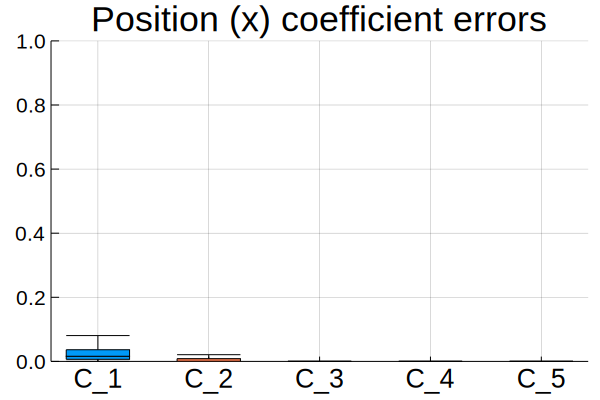

In [47]:
dim = 1
data_this_dim = rpe[:,dim,:]
@show size(data_this_dim)
@show mean(data_this_dim[:,1])
# @show trimmean(data_this_dim)
@show mean(trim(data_this_dim[:,1], prop = 0.3))
@show mean(trim(data_this_dim[:,1], prop = 0.3))
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, titlefontsize = 24)
plot!(ylims=(0,1.0))
title!("Dimension $dim")
title!("Position (x) coefficient errors")

In [48]:
png("xcoeffs.png")

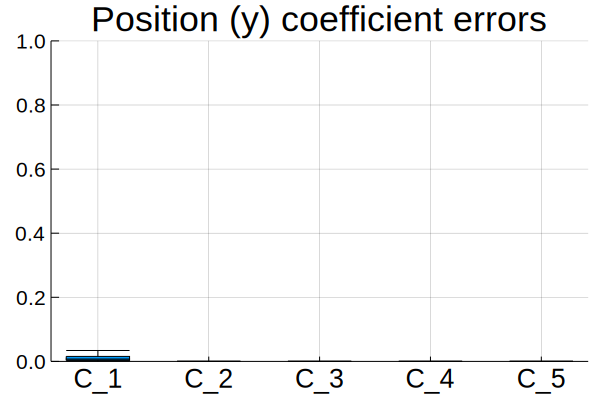

In [49]:
dim = 2
data_this_dim = rpe[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, titlefontsize = 24)
plot!(ylims=(0,1.0))
title!("Dimension $dim")
title!("Position (y) coefficient errors")

In [50]:
png("ycoeffs.png")

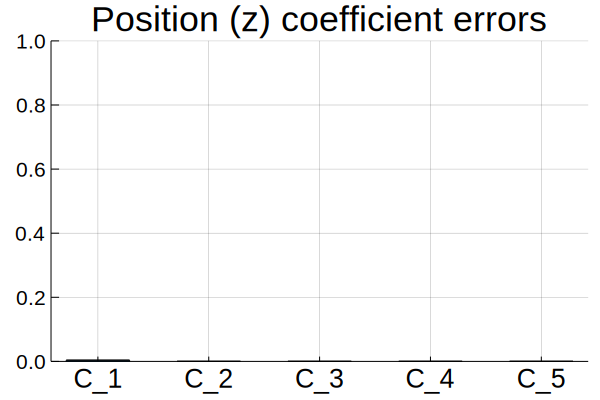

In [51]:
dim = 3
data_this_dim = rpe[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, titlefontsize = 24)
plot!(ylims=(0,1.0))
title!("Dimension $dim")
title!("Position (z) coefficient errors")

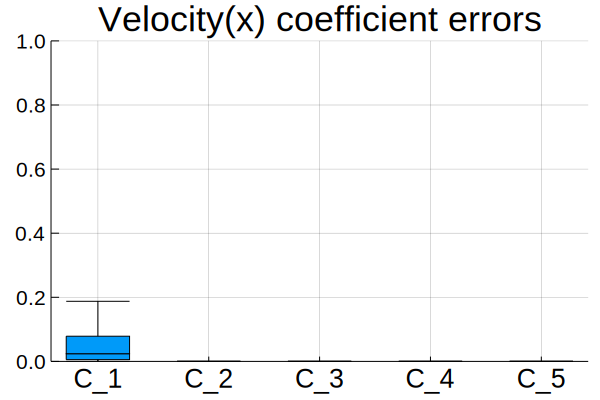

In [52]:
dim = 14
data_this_dim = rpe[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, titlefontsize = 24)
plot!(ylims=(0,1.0))
title!("Dimension $dim")
title!("Velocity(x) coefficient errors")

In [53]:
png("vxcoeffs.png")

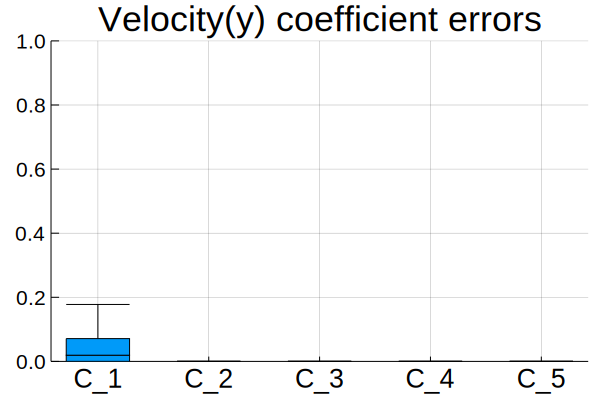

In [54]:
dim = 15
data_this_dim = rpe[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, titlefontsize = 24)
plot!(ylims=(0,1.0))
title!("Dimension $dim")
title!("Velocity(y) coefficient errors")

In [55]:
png("vycoeffs.png")

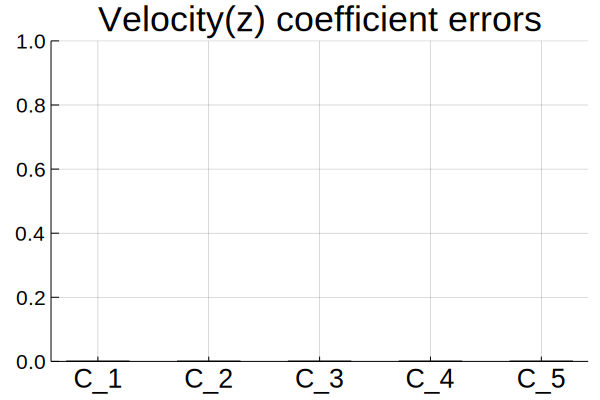

In [42]:
dim = 16
data_this_dim = rpe[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, titlefontsize = 24)
plot!(ylims=(0,1.0))
title!("Dimension $dim")
title!("Velocity(z) coefficient errors")

## Use the symmetric mean absolute percentage error to prevent errors from blowing up

In [30]:
@show extrema(abs.(true_coeffs_matrix))

extrema(abs.(true_coeffs_matrix)) = (1.1481266902236024e-21, 10.039947061851288)


(1.1481266902236024e-21, 10.039947061851288)

In [31]:
# https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
smape = abs.(NN_coeffs_matrix - true_coeffs_matrix)./(abs.(NN_coeffs_matrix) + abs.(true_coeffs_matrix))
@show mean(smape)
@show minimum(smape)
@show maximum(smape)

mean(smape) = 0.5067538042459264
minimum(smape) = 2.173215093694328e-9
maximum(smape) = 1.0


1.0

In [32]:
@show size(smape)

size(smape) = (1130, 19, 5)


(1130, 19, 5)

In [33]:
# Do some error filtering first
for row in 1:size(X_valid_norm,1)
    for dim in 1:(x_dim+u_dim)
        for i in 1:5
            NN_coeff = NN_coeffs_matrix[row,dim,i]
            true_coeff = true_coeffs_matrix[row,dim,i]
            if abs(NN_coeff)<=1e-4 && abs(true_coeff) <= 1e-4
                smape[row,dim,i] = 0.0
            else
                smape[row,dim,i] = abs.(NN_coeff - true_coeff)./(abs.(NN_coeff) + abs.(true_coeff))
            end
        end
    end
end
@show size(smape)

size(smape) = (1130, 19, 5)


(1130, 19, 5)

In [34]:
# using Pkg
# ENV["GRDIR"]=""
# Pkg.build("GR")

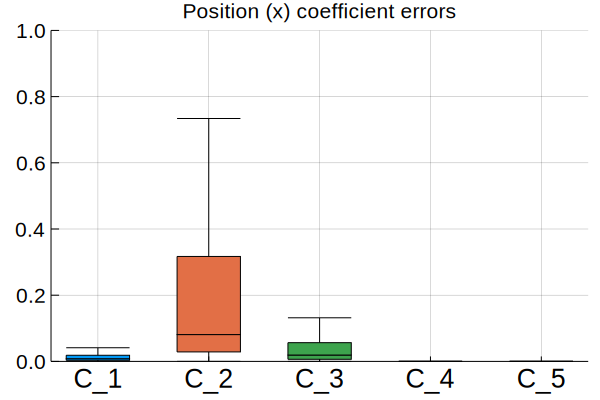

In [35]:
dim = 1
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Position (x) coefficient errors")

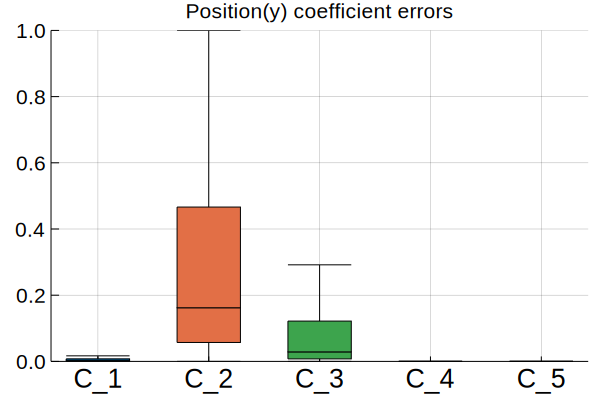

In [36]:
dim = 2
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Position(y) coefficient errors")


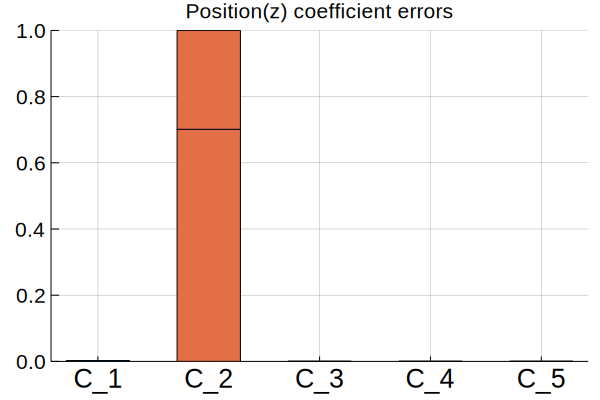

In [37]:
dim = 3
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Position(z) coefficient errors")

# Yeah this looks weird. Just change threshold to 4e-4 instead of 1e-4 and watch errors disappear.

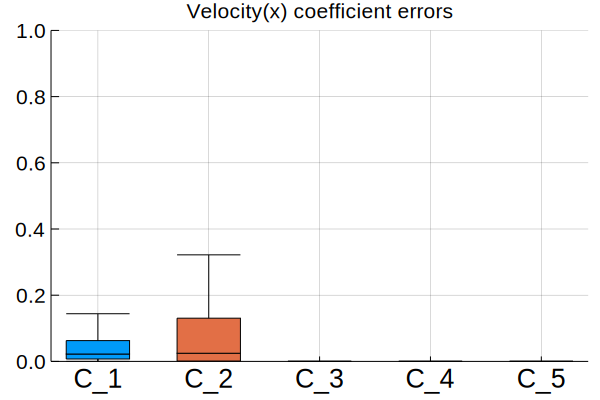

In [38]:
dim = 14
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Velocity(x) coefficient errors")


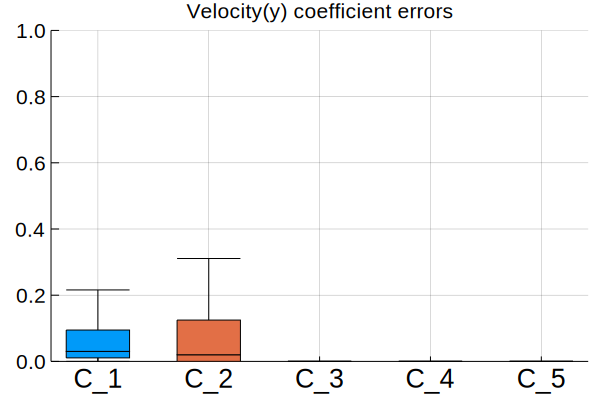

In [39]:
dim = 15
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Velocity(y) coefficient errors")


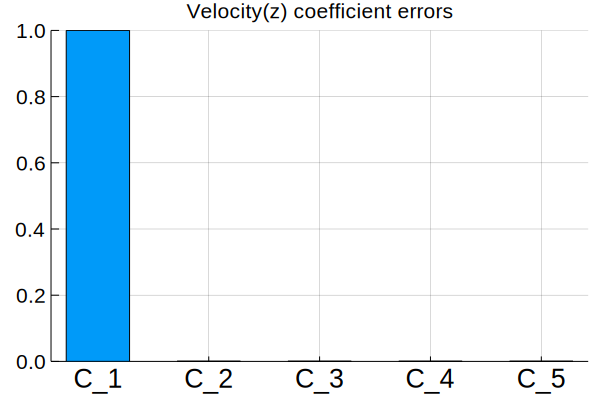

In [123]:
dim = 16
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Velocity(z) coefficient errors")


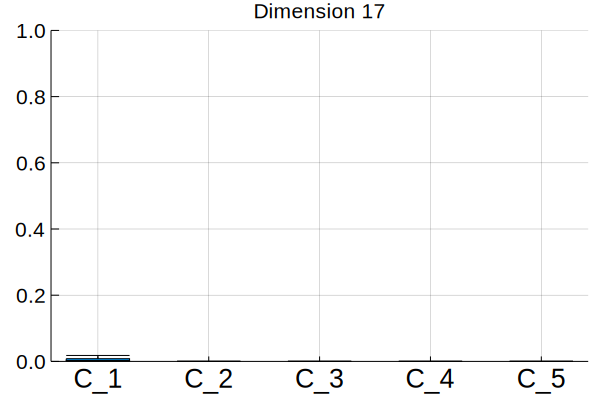

In [87]:
dim = 17
data_this_dim = smape[:,dim,:]
boxplot(["C_1" "C_2" "C_3" "C_4" "C_5"],data_this_dim,leg=false; outliers= false)
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3,ylims=(0,1.0))
title!("Dimension $dim")
title!("Dimension $dim")

## Show random coeffs and trajectories to compare

In [35]:
N = 50
tf_guess = 110.
t_array = range(0,stop=tf_guess,length=N)

0.0:2.2448979591836733:110.0

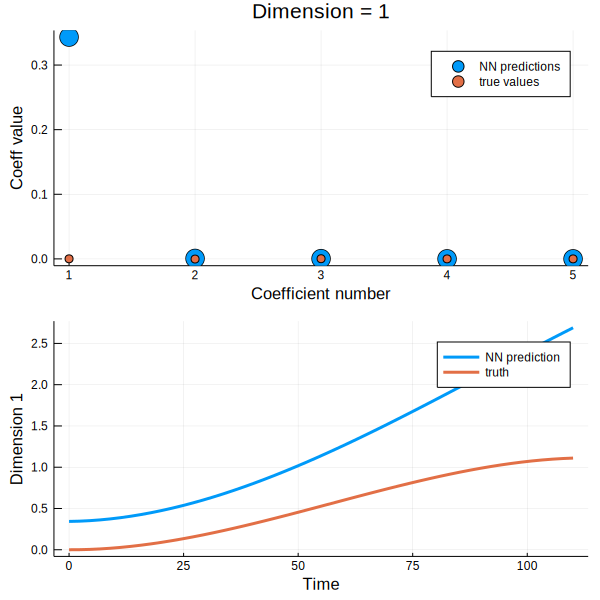

In [36]:
row = 1 # max = size(X_valid_norm,1) == 1130
dim = 1

xs = 1:1:5
NN_coeffs = NN_coeffs_matrix[row,dim,:]
true_coeffs = true_coeffs_matrix[row,dim,:]
p1 = scatter(xs,NN_coeffs,grid=true, label="NN predictions",markersize = 10)
scatter!(xs,true_coeffs,grid=true,label="true values")
title!("Dimension = $dim")
xlabel!("Coefficient number")
ylabel!("Coeff value")
plot!(legend=:best)


NN_traj = recoverXUfromCoeffsSingleDim(NN_coeffs,dim)
true_traj = recoverXUfromCoeffsSingleDim(true_coeffs,dim)
p2 = plot(t_array,NN_traj,label="NN prediction",linewidth = 3)
plot!(t_array,true_traj, label = "truth",linewidth = 3)
xlabel!("Time")
ylabel!("Dimension $dim")
plot!(legend=:best)


plot(p1,p2,
    layout=(2,1))
plot!(size=(600,600))

## Plot X and Y trajectories

x_init = [10.0, 2.22222]
x_final = [8.88889, 7.77778]
NN_coeffs_x = [9.91601, -1.3657e-8, -0.00034411, 1.66384e-6, 1.47345e-9]
true_coeffs_x = [9.99985, 0.000271587, -0.000264001, 1.54396e-6, -4.94547e-12]
NN_coeffs_y = [2.26421, -0.00187322, 0.00134741, -8.17292e-6, 1.18763e-9]
true_coeffs_y = [2.22321, -0.00148285, 0.00135483, -8.00002e-6, -1.90138e-10]


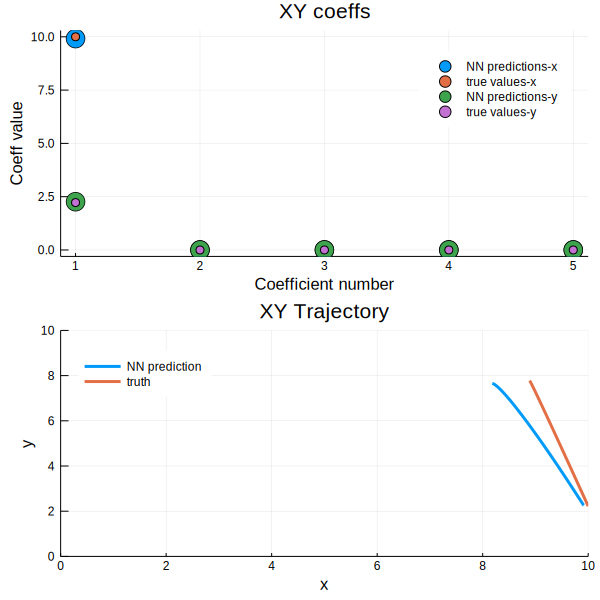

In [211]:
row = 230 # max = size(X_valid_norm,1) == 1130

x_v_norm = X_valid_norm[row,:]
(xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
x_v = x_v_norm.*xRange + xMin
x_init = x_v[1:2]
x_final = x_v[14:15]
@show x_init
@show x_final

NN_coeffs_x = NN_coeffs_matrix[row,1,:]
true_coeffs_x = true_coeffs_matrix[row,1,:]
NN_coeffs_y = NN_coeffs_matrix[row,2,:]
true_coeffs_y = true_coeffs_matrix[row,2,:]

p1 = scatter(xs,NN_coeffs_x,grid=true, label="NN predictions-x",markersize = 10)
scatter!(xs,true_coeffs_x,grid=true,label="true values-x")
scatter!(xs,NN_coeffs_y,grid=true, label="NN predictions-y",markersize = 10)
scatter!(xs,true_coeffs_y,grid=true,label="true values-y")
title!("XY coeffs")
xlabel!("Coefficient number")
ylabel!("Coeff value")
plot!(legend=:best, fg_legend = :transparent)

@show NN_coeffs_x
@show true_coeffs_x
@show NN_coeffs_y
@show true_coeffs_y

NN_x = recoverXUfromCoeffsSingleDim(NN_coeffs_x,1)
true_x = recoverXUfromCoeffsSingleDim(true_coeffs_x,1)
NN_y = recoverXUfromCoeffsSingleDim(NN_coeffs_y,2)
true_y = recoverXUfromCoeffsSingleDim(true_coeffs_y,2)
p2 = plot(NN_x,NN_y,label="NN prediction",linewidth = 3)
plot!(true_x,true_y, label = "truth",linewidth = 3)
title!("XY Trajectory")
xlabel!("x")
ylabel!("y")
plot!(legend=:topleft,fg_legend = :transparent, xlims = (0,10), ylims = (0,10))


plot(p1,p2,
    layout=(2,1))
plot!(size=(600,600))


x_init = [1.8125, 8.0]
x_final = [8.0, 5.0]


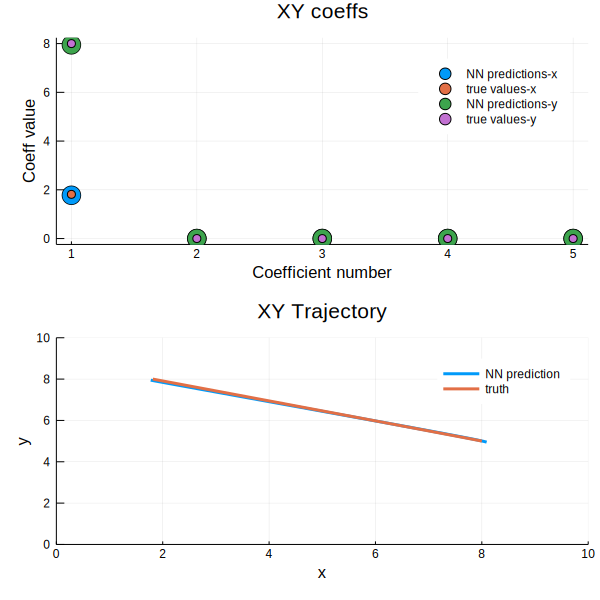

In [128]:
row = 200 # max = size(X_valid_norm,1) == 1130

x_v_norm = X_valid_norm[row,:]
(xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
x_v = x_v_norm.*xRange + xMin
x_init = x_v[1:2]
x_final = x_v[14:15]
@show x_init
@show x_final

NN_coeffs_x = NN_coeffs_matrix[row,1,:]
true_coeffs_x = true_coeffs_matrix[row,1,:]
NN_coeffs_y = NN_coeffs_matrix[row,2,:]
true_coeffs_y = true_coeffs_matrix[row,2,:]

p1 = scatter(xs,NN_coeffs_x,grid=true, label="NN predictions-x",markersize = 10)
scatter!(xs,true_coeffs_x,grid=true,label="true values-x")
scatter!(xs,NN_coeffs_y,grid=true, label="NN predictions-y",markersize = 10)
scatter!(xs,true_coeffs_y,grid=true,label="true values-y")
title!("XY coeffs")
xlabel!("Coefficient number")
ylabel!("Coeff value")
plot!(legend=:best, fg_legend = :transparent)


NN_x = recoverXUfromCoeffsSingleDim(NN_coeffs_x,1)
true_x = recoverXUfromCoeffsSingleDim(true_coeffs_x,1)
NN_y = recoverXUfromCoeffsSingleDim(NN_coeffs_y,2)
true_y = recoverXUfromCoeffsSingleDim(true_coeffs_y,2)
p2 = plot(NN_x,NN_y,label="NN prediction",linewidth = 3)
plot!(true_x,true_y, label = "truth",linewidth = 3)
title!("XY Trajectory")
xlabel!("x")
ylabel!("y")
plot!(legend=:best,fg_legend = :transparent, xlims = (0,10), ylims = (0,10))


plot(p1,p2,
    layout=(2,1))
plot!(size=(600,600))


## Compare x and vx coeffs

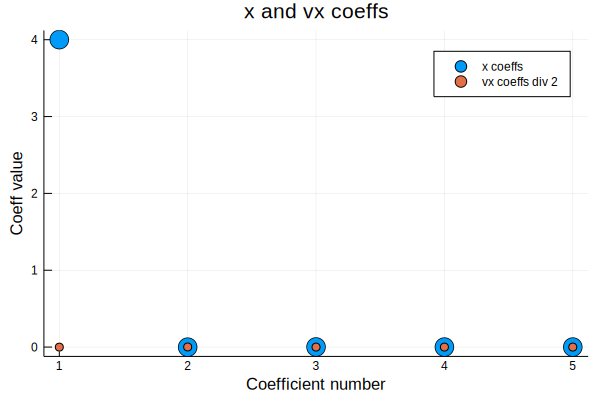

In [50]:
row = 17 # max = size(X_valid_norm,1) == 1130

xs = 1:1:5
# NN_coeffs = NN_coeffs_matrix[row,dim,:]
true_coeffs_x = true_coeffs_matrix[row,1,:]
true_coeffs_vx = true_coeffs_matrix[row,4,:]
p1 = scatter(xs,true_coeffs_x,grid=true, label="x coeffs",markersize = 10)
scatter!(xs,true_coeffs_vx./2.0,grid=true,label="vx coeffs div 2")
title!("x and vx coeffs")
xlabel!("Coefficient number")
ylabel!("Coeff value")
plot!(legend=:best)

## (Older) Manually compute mean and standard deviation

In [51]:
mean_smape = mean(smape, dims = 1)
std_smape = std(smape, dims = 1)
@show size(mean_smape)
@show size(std_smape)
num_dims = x_dim + u_dim
plots = Array{Plots.Plot{Plots.GRBackend}}(undef, num_dims, 1)
for dim in 1:num_dims
    xs = range(1,stop = 5, length = 5)
    μs = mean_smape[1,dim,:]
    σs = std_smape[1,dim,:]

    plots[dim] = scatter(xs,μs,grid=false,yerror=σs)
#     @show typeof(p1)
    title!("Dimension = $dim")
    xlabel!("Coefficient number")
    ylabel!("Relative error between NN and true value")
    plot!(legend=false)
end

size(mean_smape) = (1, 19, 5)
size(std_smape) = (1, 19, 5)


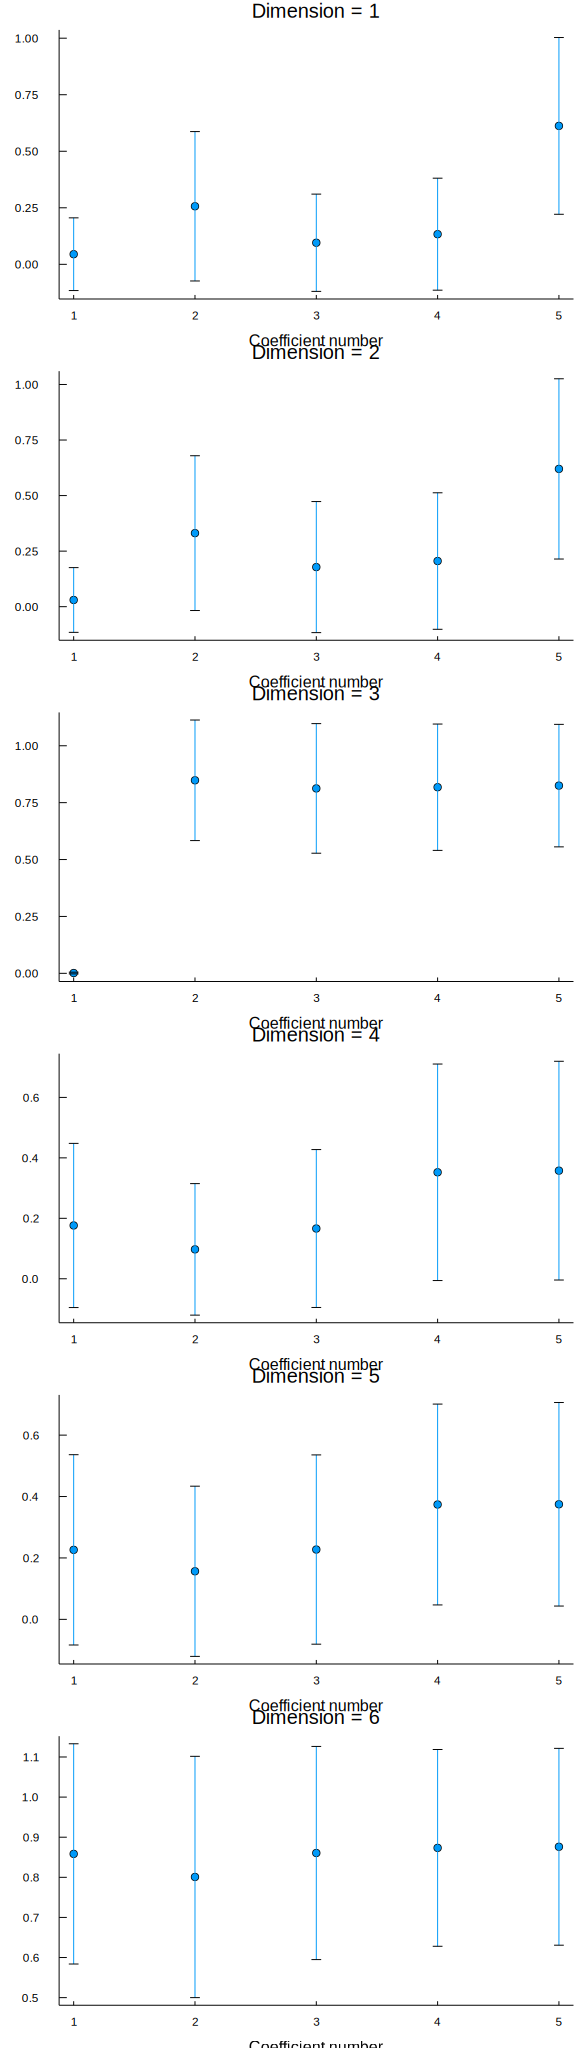

In [52]:
plot(plots[1],plots[2],plots[3],plots[4],plots[5],plots[6],
    layout=(6,1))
plot!(size=(600,6*350))

# Compare cold start and warm start GuSTO performance

### Collect the iteration number and times for each

In [28]:
x_dim = 13
u_dim = 6
num_coeffs = 5

filename = "PolyComboCoeffsNormalized.jld2"
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
(X_valid_norm, Y_valid_norm)  =getXYValid(filename)
X_valid_norm = X_valid_norm'
Y_valid_norm = Y_valid_norm'
# @show size(X_valid_norm)
# @show size(Y_valid_norm)

cold_start_data = zeros(size(X_valid_norm,1), 3)
# NOTE: cold_start_data[row,:] = [converged?, num_iter, solve_time]

warm_start_data = zeros(size(X_valid_norm,1), 3)
# NOTE: warm_start_data[row,:] = [converged?, num_iter, solve_time]

NN_run_data = zeros(size(X_valid_norm,1),1)
# NOTE: NN_run_data[row,:] = NN_solve_time

for row in 1:size(X_valid_norm,1)
# for row in 1:2
    @show row
    # For the X_valid_norm, pass each to a NN and get the Xsoln, Usoln 
    x_v_norm = X_valid_norm[row,:] # size 26
    # First convert to X_valid
    (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
    x_v = x_v_norm.*xRange + xMin
    x_init = x_v[1:13]
    x_final = x_v[14:26]
    
    model = getModelWithTwoPolyObsOneAtCorner()

    # GuSTO solution time and trajectory
    time_start = time_ns()
    model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model, false)
    gusto_solve_time = (time_ns() - time_start)/10^9
    cold_start_data[row,:]= [isConverged, numIter, gusto_solve_time]
    println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

    # NN prediction time and trajectory
    time_start = time_ns()
    X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
    NN_solve_time = (time_ns() - time_start)/10^9
    NN_run_data[row,1]= NN_solve_time
    @show NN_solve_time

    # GuSTO warm start solution time and trajectory
    time_start = time_ns()
    model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
    gusto_warm_solve_time = (time_ns() - time_start)/10^9
    warm_start_data[row,:]= [isConverged, numIter_warm, gusto_warm_solve_time]
    println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")
    
    println("")

#     plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])

    
    
    
#     # NN prediction time and trajectory
#     NN_coeffs = getNNCoeffsCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
# #     @show size(NN_coeffs)

#     # For the Y_valid_norm, these are 95 coefficients
#     y_v_norm = Y_valid_norm[row,:] # size 95
#     # First convert to Y_valid
#     (xMin, yMin, xRange, yRange) = getDataParamsFromHDF5Combo(paramsFileName)
#     true_coeffs = y_v_norm.*yRange + yMin
# #     @show size(true_coeffs)

#     for dim in 1:(x_dim+u_dim)
#         true_cf_this = true_coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
#         NN_cf_this = NN_coeffs[((dim-1)*num_coeffs + 1): (dim*num_coeffs)]
#         true_coeffs_matrix[row,dim,:] = true_cf_this
#         NN_coeffs_matrix[row,dim,:] = NN_cf_this
#     end
    if mod(row,10) == 0
        @save "coldstartwarmstartdata.jld2" cold_start_data warm_start_data NN_run_data
        println("Intermediate save")
        println("")
    end
end
@save "coldstartwarmstartdata.jld2" cold_start_data warm_start_data NN_run_data
print("All GuSTO warm start, cold start and NN run times are saved")            

row = 1
GuSTO solve time = 2.714230343 (6 iterations)
NN_solve_time = 0.001656792
GuSTO warm started solve time = 2.532885632 (5 iterations)

row = 2
GuSTO solve time = 3.526867846 (8 iterations)
NN_solve_time = 0.001814397
GuSTO warm started solve time = 5.808556339 (12 iterations)

row = 3
GuSTO solve time = 2.349790236 (5 iterations)
NN_solve_time = 0.001826795
GuSTO warm started solve time = 2.489891548 (5 iterations)

row = 4
GuSTO solve time = 2.60603577 (6 iterations)
NN_solve_time = 0.00174289
GuSTO warm started solve time = 2.249920814 (5 iterations)

row = 5
GuSTO solve time = 2.189115501 (5 iterations)
NN_solve_time = 0.001750169
GuSTO warm started solve time = 2.404912783 (5 iterations)

row = 6
GuSTO solve time = 2.417038132 (5 iterations)
NN_solve_time = 0.001893765
GuSTO warm started solve time = 2.567826798 (5 iterations)

row = 7
GuSTO solve time = 2.162796198 (5 iterations)
NN_solve_time = 0.001820388
GuSTO warm started solve time = 2.698600475 (5 iterations)

row = 8

GuSTO warm started solve time = 2.401300491 (5 iterations)

row = 114
GuSTO solve time = 26.003989594 (51 iterations)
NN_solve_time = 0.001758772
GuSTO warm started solve time = 11.12755476 (21 iterations)

row = 115
GuSTO solve time = 2.153073388 (5 iterations)
NN_solve_time = 0.001832214
GuSTO warm started solve time = 2.196577138 (5 iterations)

row = 116
GuSTO solve time = 13.434173827 (26 iterations)
NN_solve_time = 0.001867643
GuSTO warm started solve time = 5.287806212 (11 iterations)

row = 117
GuSTO solve time = 2.525194575 (5 iterations)
NN_solve_time = 0.002386845
GuSTO warm started solve time = 2.422108837 (5 iterations)

row = 118
GuSTO solve time = 2.300314985 (5 iterations)
NN_solve_time = 0.009134862
GuSTO warm started solve time = 2.402965715 (5 iterations)

row = 119
GuSTO solve time = 4.066994008 (9 iterations)
NN_solve_time = 0.001856667
GuSTO warm started solve time = 3.432905487 (7 iterations)

row = 120
GuSTO solve time = 5.69494748 (12 iterations)
NN_solve_time 

GuSTO warm started solve time = 5.808708117 (12 iterations)

row = 226
GuSTO solve time = 2.082187502 (5 iterations)
NN_solve_time = 0.001833265
GuSTO warm started solve time = 2.098539003 (5 iterations)

row = 227
GuSTO solve time = 1.977450431 (5 iterations)
NN_solve_time = 0.001825161
GuSTO warm started solve time = 2.480741764 (5 iterations)

row = 228
GuSTO solve time = 2.122257909 (5 iterations)
NN_solve_time = 0.001816205
GuSTO warm started solve time = 2.349119409 (5 iterations)

row = 229
GuSTO solve time = 4.294883432 (9 iterations)
NN_solve_time = 0.001793792
GuSTO warm started solve time = 8.23485856 (17 iterations)

row = 230
GuSTO solve time = 2.253543463 (5 iterations)
NN_solve_time = 0.001645739
GuSTO warm started solve time = 2.454437754 (5 iterations)

Intermediate save

row = 231
GuSTO solve time = 2.21146616 (5 iterations)
NN_solve_time = 0.001724284
GuSTO warm started solve time = 2.319425275 (5 iterations)

row = 232
GuSTO solve time = 2.349524374 (5 iterations)
N

GuSTO warm started solve time = 3.557415352 (7 iterations)

row = 338
GuSTO solve time = 2.520341432 (6 iterations)
NN_solve_time = 0.001775881
GuSTO warm started solve time = 2.420223543 (5 iterations)

row = 339
GuSTO solve time = 2.287019757 (5 iterations)
NN_solve_time = 0.001870523
GuSTO warm started solve time = 2.708116822 (5 iterations)

row = 340
GuSTO solve time = 2.28478635 (5 iterations)
NN_solve_time = 0.001725555
GuSTO warm started solve time = 2.409674462 (5 iterations)

Intermediate save

row = 341
GuSTO solve time = 2.466046396 (5 iterations)
NN_solve_time = 0.001800983
GuSTO warm started solve time = 2.498761674 (5 iterations)

row = 342
GuSTO solve time = 2.241050864 (5 iterations)
NN_solve_time = 0.001870924
GuSTO warm started solve time = 2.402587151 (5 iterations)

row = 343
GuSTO solve time = 3.864390552 (9 iterations)
NN_solve_time = 0.001852496
GuSTO warm started solve time = 4.267970948 (9 iterations)

row = 344
GuSTO solve time = 2.215525969 (5 iterations)
NN

GuSTO warm started solve time = 2.501050487 (5 iterations)

row = 450
GuSTO solve time = 2.251423663 (5 iterations)
NN_solve_time = 0.001898689
GuSTO warm started solve time = 2.550594271 (5 iterations)

Intermediate save

row = 451
GuSTO solve time = 7.68105935 (16 iterations)
NN_solve_time = 0.001895982
GuSTO warm started solve time = 3.812436869 (7 iterations)

row = 452
GuSTO solve time = 2.026763149 (5 iterations)
NN_solve_time = 0.001836573
GuSTO warm started solve time = 3.368143637 (7 iterations)

row = 453
GuSTO solve time = 2.189918467 (5 iterations)
NN_solve_time = 0.001842871
GuSTO warm started solve time = 2.580844245 (5 iterations)

row = 454
GuSTO solve time = 2.146882056 (5 iterations)
NN_solve_time = 0.001778392
GuSTO warm started solve time = 2.259146495 (5 iterations)

row = 455
GuSTO solve time = 2.190103417 (5 iterations)
NN_solve_time = 0.001850203
GuSTO warm started solve time = 2.293150135 (5 iterations)

row = 456
GuSTO solve time = 2.553052216 (5 iterations)
N

GuSTO warm started solve time = 7.565944903 (14 iterations)

row = 562
GuSTO solve time = 4.011140791 (9 iterations)
NN_solve_time = 0.001954048
GuSTO warm started solve time = 2.475670238 (5 iterations)

row = 563
GuSTO solve time = 2.745744743 (6 iterations)
NN_solve_time = 0.001931179
GuSTO warm started solve time = 4.391317344 (8 iterations)

row = 564
GuSTO solve time = 2.281541841 (5 iterations)
NN_solve_time = 0.00202622
GuSTO warm started solve time = 2.350754521 (5 iterations)

row = 565
GuSTO solve time = 2.649915004 (5 iterations)
NN_solve_time = 0.00190435
GuSTO warm started solve time = 2.518880258 (5 iterations)

row = 566
GuSTO solve time = 2.317111015 (5 iterations)
NN_solve_time = 0.001845458
GuSTO warm started solve time = 2.31787857 (5 iterations)

row = 567
GuSTO solve time = 2.194169424 (5 iterations)
NN_solve_time = 0.00174038
GuSTO warm started solve time = 2.477134461 (5 iterations)

row = 568
GuSTO solve time = 2.601421266 (5 iterations)
NN_solve_time = 0.00166

GuSTO warm started solve time = 2.394546332 (5 iterations)

row = 674
GuSTO solve time = 4.621995201 (10 iterations)
NN_solve_time = 0.001793693
GuSTO warm started solve time = 19.588378681 (43 iterations)

row = 675
GuSTO solve time = 2.459610168 (5 iterations)
NN_solve_time = 0.001830029
GuSTO warm started solve time = 2.723700686 (5 iterations)

row = 676
GuSTO solve time = 2.718637598 (6 iterations)
NN_solve_time = 0.001675869
GuSTO warm started solve time = 7.225146776 (14 iterations)

row = 677
GuSTO solve time = 3.523291621 (7 iterations)
NN_solve_time = 0.001653039
GuSTO warm started solve time = 6.349209959 (13 iterations)

row = 678
GuSTO solve time = 2.183951857 (5 iterations)
NN_solve_time = 0.001810859
GuSTO warm started solve time = 2.535258816 (5 iterations)

row = 679
GuSTO solve time = 4.112301239 (9 iterations)
NN_solve_time = 0.001769318
GuSTO warm started solve time = 3.047799663 (6 iterations)

row = 680
GuSTO solve time = 7.883145204 (16 iterations)
NN_solve_time 

GuSTO warm started solve time = 2.620650307 (5 iterations)

row = 786
GuSTO solve time = 2.247900333 (5 iterations)
NN_solve_time = 0.001951088
GuSTO warm started solve time = 2.420468559 (5 iterations)

row = 787
GuSTO solve time = 2.391290688 (5 iterations)
NN_solve_time = 0.001960882
GuSTO warm started solve time = 2.427421263 (5 iterations)

row = 788
GuSTO solve time = 2.402108018 (5 iterations)
NN_solve_time = 0.00189965
GuSTO warm started solve time = 2.599629785 (5 iterations)

row = 789
GuSTO solve time = 2.685669275 (6 iterations)
NN_solve_time = 0.00888315
GuSTO warm started solve time = 2.417002425 (5 iterations)

row = 790
GuSTO solve time = 2.150046098 (5 iterations)
NN_solve_time = 0.001846814
GuSTO warm started solve time = 2.519378119 (5 iterations)

Intermediate save

row = 791
GuSTO solve time = 2.476245734 (5 iterations)
NN_solve_time = 0.001879768
GuSTO warm started solve time = 2.443163764 (5 iterations)

row = 792
GuSTO solve time = 9.231260651 (18 iterations)
NN

GuSTO warm started solve time = 2.296387765 (5 iterations)

row = 842
GuSTO solve time = 2.22284533 (5 iterations)
NN_solve_time = 0.001807277
GuSTO warm started solve time = 2.310907963 (5 iterations)

row = 843
GuSTO solve time = 2.214119535 (5 iterations)
NN_solve_time = 0.00182957
GuSTO warm started solve time = 2.406000473 (5 iterations)

row = 844
GuSTO solve time = 2.138973091 (5 iterations)
NN_solve_time = 0.001796936
GuSTO warm started solve time = 2.520253456 (5 iterations)

row = 845
GuSTO solve time = 2.062144906 (5 iterations)
NN_solve_time = 0.001826067
GuSTO warm started solve time = 2.133842597 (5 iterations)

row = 846
GuSTO solve time = 2.412585044 (5 iterations)
NN_solve_time = 0.001812432
GuSTO warm started solve time = 2.560950315 (5 iterations)

row = 847
GuSTO solve time = 2.267419516 (5 iterations)
NN_solve_time = 0.001825008
GuSTO warm started solve time = 2.34983863 (5 iterations)

row = 848
GuSTO solve time = 2.291960684 (5 iterations)
NN_solve_time = 0.00184

GuSTO warm started solve time = 2.378052454 (5 iterations)

row = 954
GuSTO solve time = 2.476572176 (5 iterations)
NN_solve_time = 0.001640359
GuSTO warm started solve time = 2.557154151 (5 iterations)

row = 955
GuSTO solve time = 6.197643896 (13 iterations)
NN_solve_time = 0.001851433
GuSTO warm started solve time = 3.953055238 (8 iterations)

row = 956
GuSTO solve time = 2.118593113 (5 iterations)
NN_solve_time = 0.001830605
GuSTO warm started solve time = 2.374330708 (5 iterations)

row = 957
GuSTO solve time = 22.944757676 (45 iterations)
NN_solve_time = 0.001886686
GuSTO warm started solve time = 13.562818481 (25 iterations)

row = 958
GuSTO solve time = 7.494273201 (15 iterations)
NN_solve_time = 0.001833541
GuSTO warm started solve time = 10.96630337 (22 iterations)

row = 959
GuSTO solve time = 2.345416464 (5 iterations)
NN_solve_time = 0.001801922
GuSTO warm started solve time = 2.403742602 (5 iterations)

row = 960
GuSTO solve time = 3.842573151 (8 iterations)
NN_solve_time

GuSTO warm started solve time = 2.661921948 (5 iterations)

row = 1066
GuSTO solve time = 2.289971459 (5 iterations)
NN_solve_time = 0.001851648
GuSTO warm started solve time = 5.082048334 (10 iterations)

row = 1067
GuSTO solve time = 3.737497706 (8 iterations)
NN_solve_time = 0.001906927
GuSTO warm started solve time = 3.403628555 (7 iterations)

row = 1068
GuSTO solve time = 2.176078623 (5 iterations)
NN_solve_time = 0.001937599
GuSTO warm started solve time = 2.291313222 (5 iterations)

row = 1069
GuSTO solve time = 2.322204817 (5 iterations)
NN_solve_time = 0.001780588
GuSTO warm started solve time = 2.514696869 (5 iterations)

row = 1070
GuSTO solve time = 2.188477748 (5 iterations)
NN_solve_time = 0.001852733
GuSTO warm started solve time = 2.426383444 (5 iterations)

Intermediate save

row = 1071
GuSTO solve time = 2.684005258 (6 iterations)
NN_solve_time = 0.00190139
GuSTO warm started solve time = 4.079183057 (8 iterations)

row = 1072
GuSTO solve time = 2.220556403 (5 iterat

GuSTO warm started solve time = 2.399535338 (5 iterations)

row = 1122
GuSTO solve time = 2.304468323 (5 iterations)
NN_solve_time = 0.001816809
GuSTO warm started solve time = 3.018905101 (6 iterations)

row = 1123
GuSTO solve time = 2.317217608 (5 iterations)
NN_solve_time = 0.002069241
GuSTO warm started solve time = 2.538159896 (5 iterations)

row = 1124
GuSTO solve time = 2.31435733 (5 iterations)
NN_solve_time = 0.001993634
GuSTO warm started solve time = 6.232649001 (13 iterations)

row = 1125
GuSTO solve time = 2.300001984 (5 iterations)
NN_solve_time = 0.001852141
GuSTO warm started solve time = 2.530775791 (5 iterations)

row = 1126
GuSTO solve time = 2.413151003 (5 iterations)
NN_solve_time = 0.001892334
GuSTO warm started solve time = 4.278464441 (8 iterations)

row = 1127
GuSTO solve time = 2.090742698 (5 iterations)
NN_solve_time = 0.002144827
GuSTO warm started solve time = 4.234428201 (9 iterations)

row = 1128
GuSTO solve time = 3.80092553 (9 iterations)
NN_solve_time 

In [29]:
@show cold_start_data

cold_start_data = [1.0 6.0 2.71423; 1.0 8.0 3.52687; 1.0 5.0 2.34979; 1.0 6.0 2.60604; 1.0 5.0 2.18912; 1.0 5.0 2.41704; 1.0 5.0 2.1628; 1.0 5.0 2.28232; 1.0 42.0 21.3166; 1.0 5.0 2.28218; 1.0 5.0 2.63995; 1.0 12.0 6.39065; 1.0 5.0 2.3122; 1.0 11.0 5.06311; 1.0 8.0 3.73068; 1.0 5.0 2.22857; 1.0 5.0 2.37294; 1.0 6.0 2.72134; 1.0 5.0 2.14812; 1.0 6.0 2.72582; 1.0 5.0 2.4651; 1.0 51.0 27.0558; 1.0 5.0 2.1918; 1.0 8.0 3.61413; 1.0 5.0 2.33641; 1.0 5.0 2.32241; 1.0 9.0 4.31091; 1.0 5.0 2.27544; 1.0 5.0 2.16644; 1.0 26.0 12.5022; 1.0 5.0 2.4153; 1.0 5.0 2.28447; 1.0 8.0 3.51976; 1.0 5.0 2.21211; 1.0 5.0 2.22242; 1.0 5.0 2.2984; 1.0 8.0 3.93104; 1.0 17.0 8.0984; 1.0 5.0 2.3678; 1.0 5.0 2.2015; 1.0 15.0 8.29586; 1.0 5.0 2.41873; 1.0 8.0 3.83096; 1.0 5.0 2.04495; 1.0 5.0 2.26785; 1.0 5.0 2.20272; 1.0 6.0 2.68918; 1.0 7.0 3.02827; 1.0 5.0 2.22812; 1.0 5.0 2.20027; 1.0 5.0 2.20577; 1.0 5.0 2.34827; 1.0 7.0 3.02329; 1.0 5.0 2.04379; 1.0 5.0 2.21663; 1.0 16.0 7.5262; 1.0 5.0 2.39078; 1.0 5.0 2.0779

1130×3 Array{Float64,2}:
 1.0   6.0   2.71423
 1.0   8.0   3.52687
 1.0   5.0   2.34979
 1.0   6.0   2.60604
 1.0   5.0   2.18912
 1.0   5.0   2.41704
 1.0   5.0   2.1628 
 1.0   5.0   2.28232
 1.0  42.0  21.3166 
 1.0   5.0   2.28218
 1.0   5.0   2.63995
 1.0  12.0   6.39065
 1.0   5.0   2.3122 
 ⋮                  
 1.0   5.0   2.20794
 1.0   8.0   3.5867 
 1.0   5.0   2.19155
 1.0   5.0   2.30447
 1.0   5.0   2.31722
 1.0   5.0   2.31436
 1.0   5.0   2.3    
 1.0   5.0   2.41315
 1.0   5.0   2.09074
 1.0   9.0   3.80093
 1.0   5.0   2.27735
 1.0   5.0   2.23958

In [30]:
@show warm_start_data

warm_start_data = [1.0 5.0 2.53289; 1.0 12.0 5.80856; 1.0 5.0 2.48989; 1.0 5.0 2.24992; 1.0 5.0 2.40491; 1.0 5.0 2.56783; 1.0 5.0 2.6986; 1.0 5.0 2.31908; 1.0 8.0 3.99792; 1.0 6.0 3.01203; 1.0 5.0 2.62211; 1.0 14.0 7.65857; 1.0 5.0 2.50581; 0.0 200.0 97.8711; 1.0 14.0 7.02225; 1.0 6.0 2.9736; 1.0 5.0 2.58106; 1.0 7.0 3.65646; 1.0 5.0 2.35674; 1.0 11.0 5.45909; 1.0 5.0 2.67582; 1.0 8.0 4.05897; 1.0 5.0 2.38127; 1.0 13.0 6.70558; 1.0 5.0 2.43653; 1.0 5.0 2.46162; 1.0 9.0 4.67482; 1.0 5.0 2.43007; 1.0 5.0 2.34689; 1.0 10.0 5.07161; 1.0 5.0 2.33969; 1.0 5.0 2.64093; 1.0 7.0 3.44349; 1.0 5.0 2.35967; 1.0 5.0 2.27474; 1.0 5.0 2.60259; 1.0 7.0 3.58469; 1.0 20.0 10.9136; 1.0 6.0 3.33027; 1.0 5.0 2.61197; 1.0 23.0 11.4441; 1.0 5.0 2.54937; 1.0 7.0 3.63397; 1.0 5.0 2.37559; 0.0 200.0 91.2079; 1.0 5.0 2.39744; 1.0 5.0 2.40191; 1.0 5.0 2.50833; 1.0 5.0 2.45179; 1.0 6.0 3.13923; 1.0 5.0 2.23186; 1.0 5.0 2.58735; 1.0 8.0 3.79357; 1.0 5.0 2.20335; 1.0 5.0 2.40632; 1.0 14.0 6.47868; 1.0 5.0 2.3292; 1.

1130×3 Array{Float64,2}:
 1.0   5.0   2.53289
 1.0  12.0   5.80856
 1.0   5.0   2.48989
 1.0   5.0   2.24992
 1.0   5.0   2.40491
 1.0   5.0   2.56783
 1.0   5.0   2.6986 
 1.0   5.0   2.31908
 1.0   8.0   3.99792
 1.0   6.0   3.01203
 1.0   5.0   2.62211
 1.0  14.0   7.65857
 1.0   5.0   2.50581
 ⋮                  
 1.0   5.0   2.4559 
 1.0  26.0  13.1949 
 1.0   5.0   2.39954
 1.0   6.0   3.01891
 1.0   5.0   2.53816
 1.0  13.0   6.23265
 1.0   5.0   2.53078
 1.0   8.0   4.27846
 1.0   9.0   4.23443
 1.0   5.0   2.34696
 1.0  13.0   7.04586
 1.0   5.0   2.48265

In [31]:
@show NN_run_data

NN_run_data = [0.00165679; 0.0018144; 0.00182679; 0.00174289; 0.00175017; 0.00189376; 0.00182039; 0.00184479; 0.00160971; 0.00174628; 0.00189155; 0.00176492; 0.00170759; 0.00169011; 0.00185385; 0.00218924; 0.00175421; 0.00224732; 0.0019192; 0.00177926; 0.00165819; 0.00171589; 0.00178922; 0.0018674; 0.00176208; 0.00179761; 0.00170202; 0.00174804; 0.00174904; 0.00184821; 0.00177157; 0.00184495; 0.00802945; 0.0016721; 0.00180566; 0.00180804; 0.0018796; 0.0017064; 0.00183235; 0.00191777; 0.00164081; 0.00190039; 0.00184226; 0.00936382; 0.00188697; 0.00175689; 0.00839397; 0.00176236; 0.0017875; 0.00182665; 0.00181433; 0.00180186; 0.00188078; 0.00182742; 0.00187884; 0.0018955; 0.00180371; 0.00184309; 0.0019237; 0.0018401; 0.00187696; 0.00183809; 0.00185126; 0.00177919; 0.00181702; 0.00188502; 0.00186288; 0.00881063; 0.00183939; 0.0018173; 0.00180789; 0.00180112; 0.00179431; 0.00179558; 0.00186348; 0.00180531; 0.00184266; 0.00181578; 0.00178928; 0.00175748; 0.00180632; 0.00178967; 0.00178325; 

1130×1 Array{Float64,2}:
 0.001656792
 0.001814397
 0.001826795
 0.00174289 
 0.001750169
 0.001893765
 0.001820388
 0.001844792
 0.001609711
 0.001746277
 0.001891553
 0.001764918
 0.001707595
 ⋮          
 0.001897456
 0.001868587
 0.001780532
 0.001816809
 0.002069241
 0.001993634
 0.001852141
 0.001892334
 0.002144827
 0.001945072
 0.001906113
 0.001870961

## Plotting cold and warm start data

In [132]:
@load "coldstartwarmstartdata.jld2" cold_start_data warm_start_data NN_run_data


3-element Array{Symbol,1}:
 :cold_start_data
 :warm_start_data
 :NN_run_data    

In [140]:
@show size(cold_start_data)
cold_conv = cold_start_data[:,1]
@show extrema(cold_conv)
warm_conv = warm_start_data[:,1]
@show extrema(warm_conv)

size(cold_start_data) = (1130, 3)
extrema(cold_conv) = (1.0, 1.0)
extrema(warm_conv) = (0.0, 1.0)


(0.0, 1.0)

In [144]:
for row = 1:size(cold_start_data,1)
    if warm_conv[row] == 0.0
        println("didn't converge")
        @show warm_start_data[row,2]
        continue;
    end
end


didn't converge
didn't converge
didn't converge
didn't converge
didn't converge
didn't converge
didn't converge


In [188]:
w = warm_start_data
c = cold_start_data
w_filt = [w[i,:] for i=1:size(w,1) if w[i,1]==1 && c[i,1]==1]
c_filt = [c[i,:] for i=1:size(c,1) if w[i,1]==1 && c[i,1]==1]
c_filt = Array(hcat(c_filt...)')
w_filt = Array(hcat(w_filt...)')

1123×3 Array{Float64,2}:
 1.0   5.0   2.53289
 1.0  12.0   5.80856
 1.0   5.0   2.48989
 1.0   5.0   2.24992
 1.0   5.0   2.40491
 1.0   5.0   2.56783
 1.0   5.0   2.6986 
 1.0   5.0   2.31908
 1.0   8.0   3.99792
 1.0   6.0   3.01203
 1.0   5.0   2.62211
 1.0  14.0   7.65857
 1.0   5.0   2.50581
 ⋮                  
 1.0   5.0   2.4559 
 1.0  26.0  13.1949 
 1.0   5.0   2.39954
 1.0   6.0   3.01891
 1.0   5.0   2.53816
 1.0  13.0   6.23265
 1.0   5.0   2.53078
 1.0   8.0   4.27846
 1.0   9.0   4.23443
 1.0   5.0   2.34696
 1.0  13.0   7.04586
 1.0   5.0   2.48265

In [191]:
warm_iter = w_filt[:,2]
cold_iter = c_filt[:,2]
@show mean(warm_iter)
@show mean(cold_iter)
warm_time = w_filt[:,3]
cold_time = c_filt[:,3]
@show mean(warm_time)
@show mean(cold_time)

mean(warm_iter) = 8.463045414069457
mean(cold_iter) = 9.219056099732859
mean(warm_time) = 4.232061255051647
mean(cold_time) = 4.434821645786287


4.434821645786287

mean(cold_iter) = 9.219056099732859
mean(warm_iter) = 8.463045414069457
median(cold_iter) = 5.0
median(warm_iter) = 5.0
size(diff_iter) = (1123, 2)


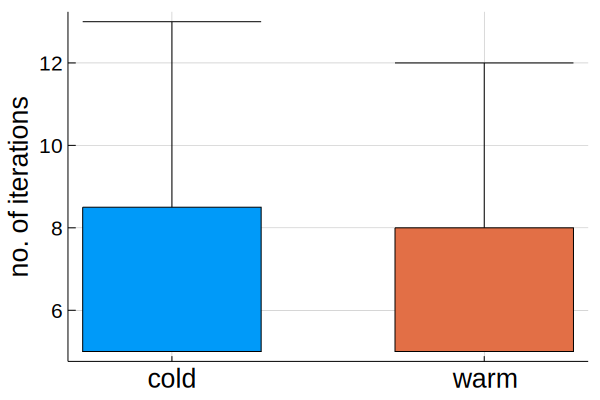

In [227]:
diff_iter = zeros(size(w_filt,1),2)
diff_iter[:,1] = cold_iter
diff_iter[:,2] = warm_iter
@show mean(cold_iter)
@show mean(warm_iter)
@show median(cold_iter)
@show median(warm_iter)

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="no. of iterations")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


mean(diff_iter[:, 1]) = 4.434821645786287
mean(diff_iter[:, 2]) = 4.232061255051647
size(diff_iter) = (1123, 2)


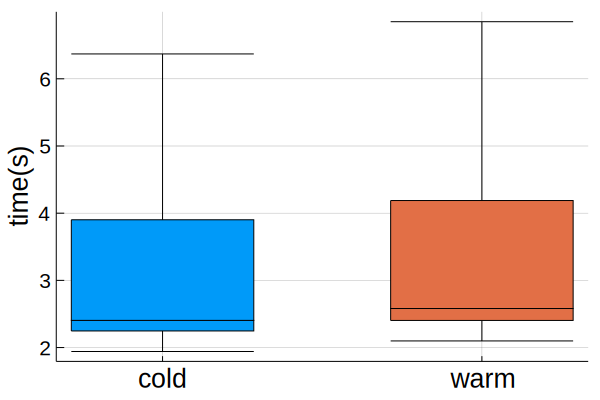

In [204]:
diff_iter = zeros(size(w_filt,1),2)
diff_iter[:,1] = cold_time
diff_iter[:,2] = warm_time
@show mean(diff_iter[:,1])
@show mean(diff_iter[:,2])

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="time(s)")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


In [210]:
diff_iter = cold_iter - warm_iter
count(x->x==0.0,diff_iter)
# count(x->x<0.0,diff_iter)

667

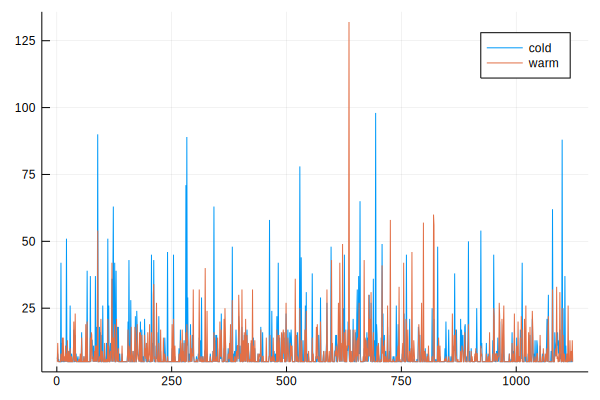

In [218]:
xs = 1:size(w_filt,1)
plot(xs, cold_iter,label="cold")
plot!(xs, warm_iter, label = "warm")


In [222]:
w_filt_large_iter = [w_filt[i,:] for i=1:size(w_filt,1) if c_filt[i,2]>=10]
c_filt_large_iter = [c_filt[i,:] for i=1:size(c_filt,1) if c_filt[i,2]>=10]
c_filt_large_iter = Array(hcat(c_filt_large_iter...)')
w_filt_large_iter = Array(hcat(w_filt_large_iter...)')
@show size(w_filt_large_iter)
@show size(c_filt_large_iter)

size(w_filt_large_iter) = (244, 3)
size(c_filt_large_iter) = (244, 3)


(244, 3)

mean(diff_iter[:, 1]) = 22.327868852459016
mean(diff_iter[:, 2]) = 14.540983606557377
median(diff_iter[:, 1]) = 16.0
median(diff_iter[:, 2]) = 12.0
size(diff_iter) = (244, 2)


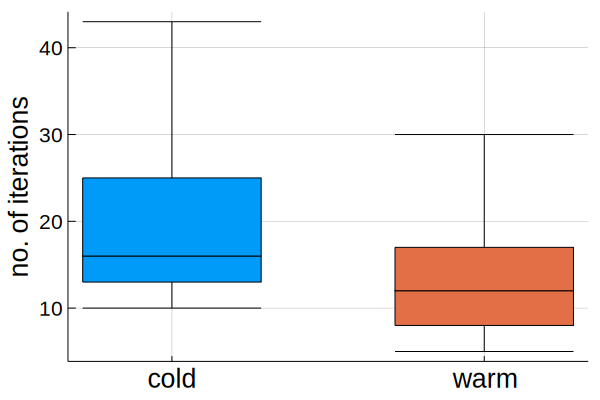

In [228]:
diff_iter = zeros(size(w_filt_large_iter,1),2)
diff_iter[:,1] = c_filt_large_iter[:,2]
diff_iter[:,2] = w_filt_large_iter[:,2]
@show mean(diff_iter[:,1])
@show mean(diff_iter[:,2])
@show median(diff_iter[:,1])
@show median(diff_iter[:,2])

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="no. of iterations")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


In [232]:
w_filt_large_iter = [w_filt[i,:] for i=1:size(w_filt,1) if c_filt[i,2]>6]
c_filt_large_iter = [c_filt[i,:] for i=1:size(c_filt,1) if c_filt[i,2]>6]
c_filt_large_iter = Array(hcat(c_filt_large_iter...)')
w_filt_large_iter = Array(hcat(w_filt_large_iter...)')
@show size(w_filt_large_iter)
@show size(c_filt_large_iter)

size(w_filt_large_iter) = (405, 3)
size(c_filt_large_iter) = (405, 3)


(405, 3)

mean(diff_iter[:, 1]) = 16.59259259259259
mean(diff_iter[:, 2]) = 13.57037037037037
median(diff_iter[:, 1]) = 12.0
median(diff_iter[:, 2]) = 10.0
size(diff_iter) = (405, 2)


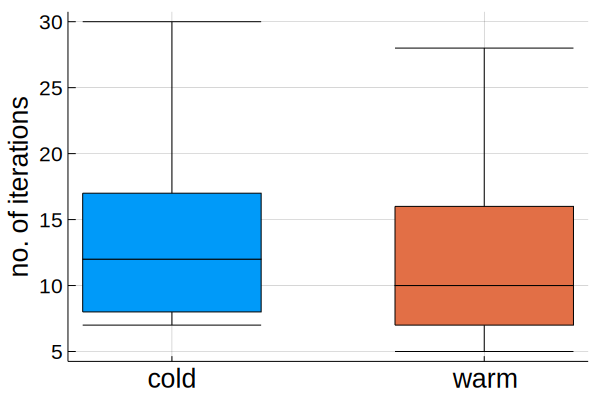

In [235]:
diff_iter = zeros(size(w_filt_large_iter,1),2)
diff_iter[:,1] = c_filt_large_iter[:,2]
diff_iter[:,2] = w_filt_large_iter[:,2]
@show mean(diff_iter[:,1])
@show mean(diff_iter[:,2])
@show median(diff_iter[:,1])
@show median(diff_iter[:,2])

@show size(diff_iter)
boxplot(["cold" "warm"],diff_iter,leg=false; outliers= false)
plot!(yaxis="no. of iterations")
plot!(xtickfontsize=18, ytickfontsize = 14, grid=true, gridalpha=0.3, guidefontsize = 18)
# title!("Difference between warm start and cold start iterations")


# Warm-starting
- Find GuSTO solution (time it, plot it)
- Find NN prediction (time it, plot it) 
- Start GuSTO with NN prediction (time it, plot it)

In [ ]:
x_start= [0.0, 7.0, 0.0]
x_goal = [8.0, 7.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


## Refine plots

In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
# xlabel!("x")
# ylabel!("y")
xaxis!(:off)
yaxis!(:off)
plot!(framestyle = :box)

In [ ]:
png("addABorder")

In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], 2.5, 3, 0.002, 1.78, 1)
# plot!(legend = :best, legendfontsize = 9, fg_legend = :transparent)
# plot!(size = (500,500))
# plot!(aspect_ratio = 1.0)
plot!(legend = :best)


In [ ]:
png("testing")

In [ ]:
x_start= [0.0, 8.0, 0.0]
x_goal = [8.0, 8.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [3.0, 8.0, 0.0]
x_goal = [8.0, 8.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [3.0, 8.0, 0.0]
x_goal = [8.0, 3.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [0.0, 7.0, 0.0]
x_goal = [8.0, 5.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [0.0, 7.0, 0.0]
x_goal = [8.0, 8.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [0.0, 7.0, 0.0]
x_goal = [7.0, 6.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeParams.h5"
jsonFileName = "SimpleAstrobee.json"
weightsFileName = "SimpleAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


# Try new poly combo model

In [ ]:
x_start= [5.55555556, 1.11111111, 0.5]
x_goal = [7.77777778, 6.66666667, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("Simple case not bad 2")

In [ ]:
x_start= [0.5, 7.0, 0.5]
x_goal = [6.0, 2.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("2x good speedup")

In [ ]:
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 0.5, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# Increase convergence threshold 
model.convergence_threshold = 5.0

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("5x speedup")

In [ ]:
x_start= [0.5, 6.125, 0.5]
x_goal = [9.0, 2.75, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("NN helped you avoid obstacles 3")

# Try to add an obstacle to GuSTO now

In [ ]:
# Solve with one extra obstacle

x_start= [0.5, 6.125, 0.5]
x_goal = [9.0, 2.75, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO original solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_init, U_all_init = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN original prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time


# Add an extra obstacle
poly_obstacles = []
obs = PolygonalObstacle([7.0,4.2,0.5], [0.5, 1.0, 2.0])
push!(model.poly_obstacles, obs)


# GuSTO solution time and trajectory- COLD START
time_start = time_ns()
model, isConverged, numIter, X_all_new_cold, U_all_new_cold = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# GuSTO start solution time and trajectory- WARM START
time_start = time_ns()
model, isConverged, numIter_warm, X_all_new_warm, U_all_new_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

In [ ]:
plot_env_and_trajs(model, [X_all_init[end],X_all_new_cold[end],  X_all_new_warm[end]])

In [ ]:
x_start= [0.9375, 8.0, 0.5]
x_goal = [7.5, 2.1875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :top)

In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
xlabel!("x", guidefontsize = 13)
ylabel!("y", guidefontsize = 13)
plot!(tickfontsize = 12)


In [ ]:
png("warmstartexample")

# Get four differnt types of trajectories and compare the warm-starting

In [92]:
x_start= [0.9375, 8.0, 0.5]
x_goal = [7.5, 2.1875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



GuSTO solve time = 17.306617407 (20 iterations)
NN_solve_time = 0.211688264
GuSTO warm started solve time = 5.246600859 (7 iterations)


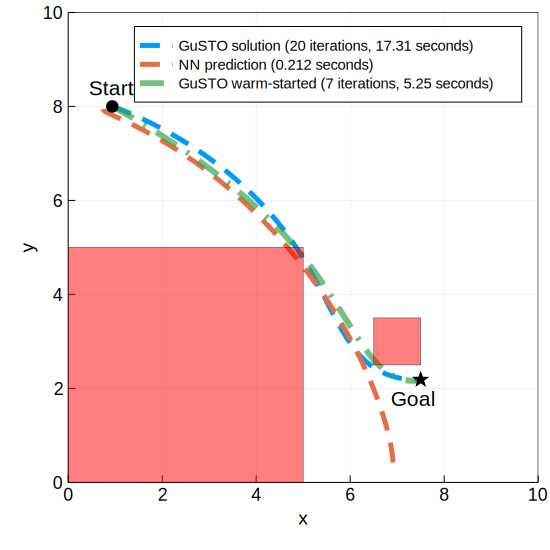

In [93]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :top)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
xlabel!("x", guidefontsize = 13)
ylabel!("y", guidefontsize = 13)
plot!(tickfontsize = 12)

In [94]:
x_start= [6.0, 1.0, 0.5]
x_goal = [7.5, 5., 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



GuSTO solve time = 11.969854348 (15 iterations)
NN_solve_time = 0.012632869
GuSTO warm started solve time = 5.101178697 (7 iterations)


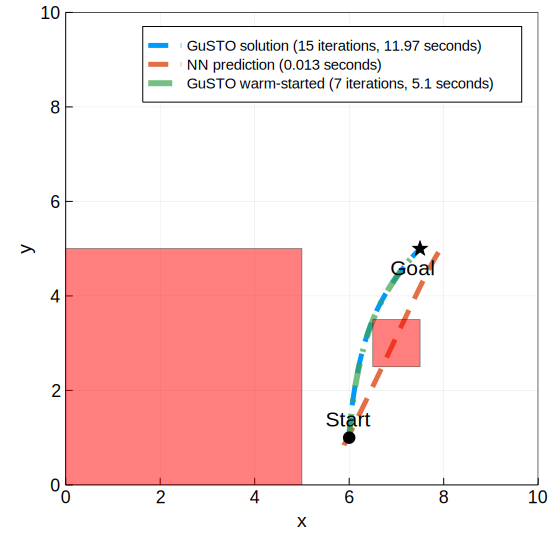

In [95]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :top)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
xlabel!("x", guidefontsize = 13)
ylabel!("y", guidefontsize = 13)
plot!(tickfontsize = 12)

In [96]:
x_start= [0.5, 6.0, 0.5]
x_goal = [9.0, 1., 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



GuSTO solve time = 15.140566363 (21 iterations)
NN_solve_time = 0.033848478
GuSTO warm started solve time = 21.651715297 (29 iterations)


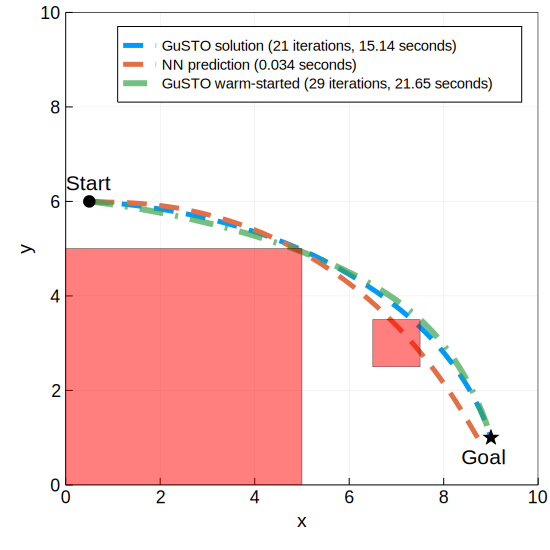

In [97]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :top)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
xlabel!("x", guidefontsize = 13)
ylabel!("y", guidefontsize = 13)
plot!(tickfontsize = 12)

In [98]:
x_start= [8.0, 1.0, 0.5]
x_goal = [5.0, 6., 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



GuSTO solve time = 11.229065241 (12 iterations)
NN_solve_time = 0.004222941
GuSTO warm started solve time = 8.522013225 (11 iterations)


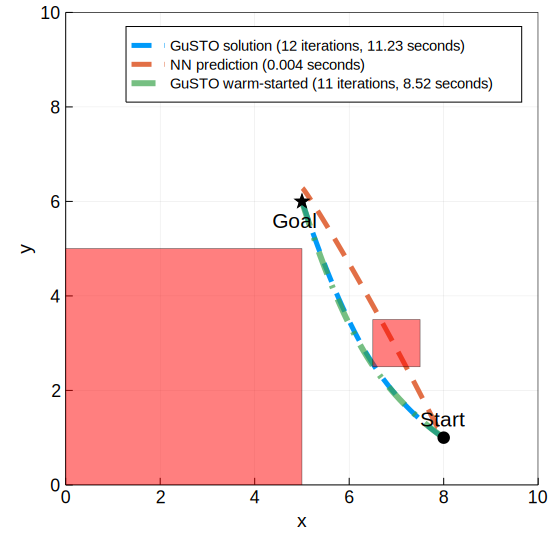

In [99]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :top)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
xlabel!("x", guidefontsize = 13)
ylabel!("y", guidefontsize = 13)
plot!(tickfontsize = 12)

# Plotting function

In [100]:
function plot_three_comp_no_label(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
    labls = ["GuSTO solution", "NN prediction", "GuSTO warm-started"]
    idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    
    
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 1)
        elseif iter == 2
            r = plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 2)
#             @show r.color
        else
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(6, :dashdot), linealpha = 0.7, lab = labls[iter], color = 3)
        end        
    end
    
    st_pt = X_all[1][idx[1]:idx[2],1]
    scatter!([st_pt[1]], [st_pt[2]], shape = :circle, markersize = 6, color = :black, lab = "")
    end_pt = X_all[1][idx[1]:idx[2],end]
    scatter!([end_pt[1]], [end_pt[2]], shape = :star, markersize = 8, color = :black, lab = "")
    annotate!([(st_pt[1]-0.5, st_pt[2]+0.4, text("Start", 14, :black, :left)), 
            (end_pt[1]+0.3, end_pt[2]-0.4, text("Goal", 14, :black, :right))])


    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black, linealpha = 0.7,
                fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(legend = :best, legendfontsize=10)
    plot!(size=(550,550))
    xlabel!("x", guidefontsize = 13)
    ylabel!("y", guidefontsize = 13)
    plot!(tickfontsize = 12)
    return fig
end

plot_three_comp_no_label (generic function with 7 methods)

In [101]:
function simplePlot(x_start, x_goal)
    x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
    x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


    # GuSTO solution time and trajectory
    model = getModelWithTwoPolyObsOneAtCorner()
    model.convergence_threshold = 5.0
    time_start = time_ns()
    model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
    gusto_solve_time = (time_ns() - time_start)/10^9
    println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

    # NN prediction time and trajectory
    paramsFileName = "PolyComboParams.h5"
    jsonFileName = "SimpleAstrobeeTemplate.json"
    weightsFileName = "PolyComboWeights.h5"
    time_start = time_ns()
    X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
    NN_solve_time = (time_ns() - time_start)/10^9
    @show NN_solve_time

    # GuSTO warm start solution time and trajectory
    model = getModelWithTwoPolyObsOneAtCorner()
    model.convergence_threshold = 5.0
    time_start = time_ns()
    model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
    gusto_warm_solve_time = (time_ns() - time_start)/10^9
    println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

    p = plot_three_comp_no_label(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
    return p
end

simplePlot (generic function with 1 method)

# Four plots in one

In [102]:
x_start= [0.9375, 8.0, 0.5]
x_goal = [7.5, 2.1875, 0.5]
p1=simplePlot(x_start, x_goal)
x_start= [6.0, 1.0, 0.5]
x_goal = [7.5, 5., 0.5]
p2=simplePlot(x_start, x_goal)
x_start= [0.5, 6.0, 0.5]
x_goal = [9.0, 1., 0.5]
p3=simplePlot(x_start, x_goal)
x_start= [8.0, 1.0, 0.5]
x_goal = [5.0, 6., 0.5]
p4=simplePlot(x_start, x_goal)
plot()
plot!(p1,p2,p3,p4)

GuSTO solve time = 15.697586834 (20 iterations)
NN_solve_time = 0.004453007
GuSTO warm started solve time = 5.911834876 (7 iterations)
GuSTO solve time = 12.350934483 (15 iterations)
NN_solve_time = 0.002080966
GuSTO warm started solve time = 5.312291175 (7 iterations)
GuSTO solve time = 17.414430276 (21 iterations)
NN_solve_time = 0.003557764
GuSTO warm started solve time = 27.126789249 (29 iterations)
GuSTO solve time = 11.171603788 (12 iterations)
NN_solve_time = 0.004093559
GuSTO warm started solve time = 10.742925575 (11 iterations)


MethodError: MethodError: no method matching Plots.Plot{Plots.GRBackend}(::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char)
Closest candidates are:
  Plots.Plot{Plots.GRBackend}(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any) where T<:AbstractBackend at /home/somrita/.julia/packages/Plots/AXUqs/src/types.jl:68

In [103]:
plot()
plot!(p2)
plot!(p1,p2)
# plot!(p1,p2,p3,p4,layout=(2,2))

MethodError: MethodError: no method matching Plots.Plot{Plots.GRBackend}(::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char, ::Char)
Closest candidates are:
  Plots.Plot{Plots.GRBackend}(::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any, ::Any) where T<:AbstractBackend at /home/somrita/.julia/packages/Plots/AXUqs/src/types.jl:68

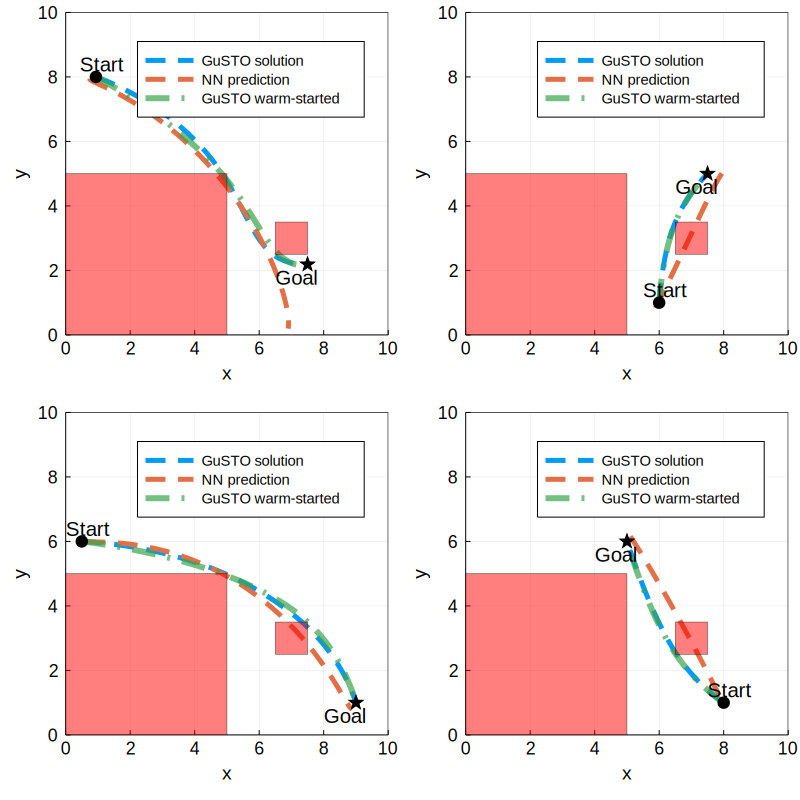

In [104]:
plot(p1,p2,p3,p4,layout=(2,2), size=(800,800))

In [ ]:
png("AllFour")

# Rejected for now

In [ ]:
x_start= [2.0, 6.0, 0.5]
x_goal = [9.0, 2., 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]


# GuSTO solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
model = getModelWithTwoPolyObsOneAtCorner()
model.convergence_threshold = 5.0
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")



In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :top)
plot!(legend = :best, legendfontsize=10)
plot!(size=(550,550))
xlabel!("x", guidefontsize = 13)
ylabel!("y", guidefontsize = 13)
plot!(tickfontsize = 12)

In [ ]:
x_start= [2.222, 10.0, 0.5]
x_goal = [6.6667, 0.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
x_start= [2.25, 5.8125, 0.5]
x_goal = [9.5, 2.1875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("NN helped you avoid both obstacles 2")

In [ ]:
x_start= [3.125, 7.6875, 0.5]
x_goal = [9.5, 3.875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :bottomright)

In [ ]:
png("Simple case not bad")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

GuSTO solve time = 40.897764688 (8 iterations)
NN_solve_time = 4.082913327
GuSTO warm started solve time = 7.942292923 (12 iterations)


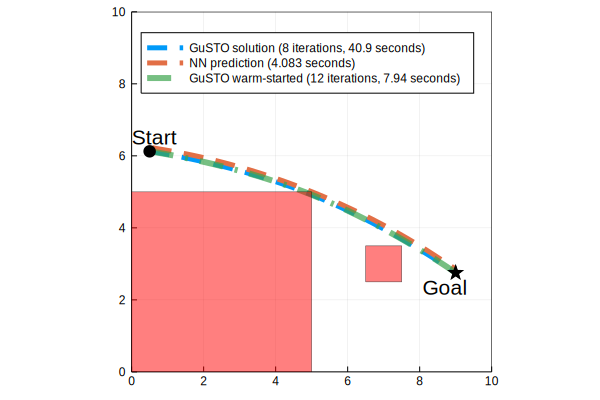

In [25]:
x_start= [0.5, 6.125, 0.5]
x_goal = [9., 2.75, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [87]:
function plot_three_comp_pyplot(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
    labls = ["GuSTO solution", "NN prediction", "GuSTO warm-started"]
    idx = [1,2]
#     local fig
#     fig = plot(framestyle = :box)
    
    
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1
            plot!(X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 1)
        elseif iter == 2
            r = plot!(X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 2)
#             @show r.color
        else
            plot!(X[idx[1],:], X[idx[2],:];line=(6, :dashdot), linealpha = 0.7, lab = labls[iter], color = 3)
        end        
    end
    
    st_pt = X_all[1][idx[1]:idx[2],1]
    scatter!([st_pt[1]], [st_pt[2]], shape = :circle, markersize = 6, color = :black, lab = "")
    end_pt = X_all[1][idx[1]:idx[2],end]
    scatter!([end_pt[1]], [end_pt[2]], shape = :star, markersize = 8, color = :black, lab = "")
    annotate!([(st_pt[1]-0.4, st_pt[2]+0.4, text("\$x_{init}\$", 22, :black, :left)), 
            (end_pt[1]+0.4, end_pt[2]-0.4, text("\$x_{final}\$", 22, :black, :right))])


    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        buf = 0.2
        r1 = r1-buf
        r2 = r2-buf
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black, linealpha = 0.7,
                fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(legend = :best, legendfontsize=10)
    plot!(size=(550,550))
    xlabel!("x", guidefontsize = 16)
#     ylabel!("y", guidefontsize = 13)
    annotate!([(-1,5,Plots.text("y",16))])
    plot!(tickfontsize = 12)
#     return fig
end

plot_three_comp_pyplot (generic function with 7 methods)

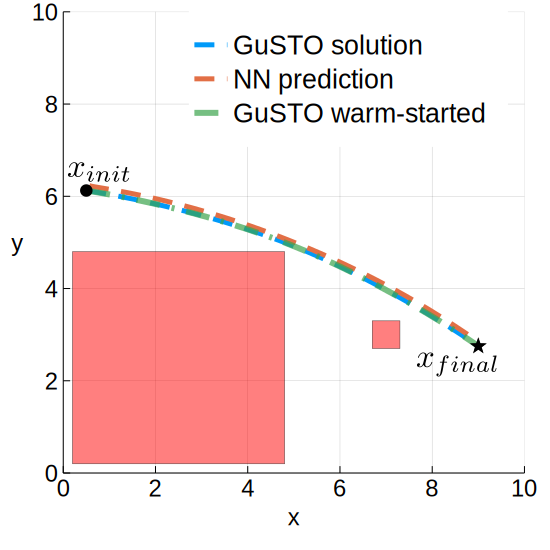

In [88]:
using PyPlot
plot()
plot_three_comp_pyplot(model, [X_all_true[end], X_soln_NN, X_all_warm[end]])
plot!(legendfontsize = 18, fg_legend=:transparent, tickfontsize = 16, guidefontsize = 16, legend=:best,yrotation = 0)
plot!(gridalpha = 0.2)

In [53]:
png("almostperfect-new")

In [262]:
png("Almost perfect 1.5x")

In [104]:
function plot_three_comp_3D_pyplot(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
    labls = ["GuSTO solution", "NN prediction", "GuSTO warm-started"]
    idx = [1,2]
#     local fig
#     fig = plot()
#     fig = plot(framestyle = :box)
    


    for obs_i = 1
        (c1,c2,c3)  =  model.poly_obstacles[obs_i].c
        dx = model.poly_obstacles[obs_i].dx
        dy = model.poly_obstacles[obs_i].dy
        dz = model.poly_obstacles[obs_i].dz
        
        xmin = c1 - dx
        xmax = c1 + dx
        ymin = c2 - dy
        ymax = c2 + dy
        zmin = c3 - dz
        zmax = c3 + dz
        zmin = 0.2
        zmax = 0.8

        a = (zmax-zmin)/0.002
        b = zmax-0.003*a

        # top and bottom surfaces
        x = range(xmin, stop = xmax, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        f(x,y) = zmax
        g(x,y) = zmin
        plot!(x,y,f, seriestype = :surface, fillalpha = 1.0)
        plot!(x,y,g, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        

        dx = range(xmin + 0.001, stop = xmin + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        h(x,y) = a*(x-xmin) +b
        plot!(dx,y,h, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymax + 0.001, stop = ymax + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        m(x,y) = a*(y-ymax)+b
        plot!(x,dy,m, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        
        dx = range(xmax + 0.001, stop = xmax + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        k(x,y) = a*(x-xmax) +b
        plot!(dx,y,k, seriestype = :surface, fillalpha = 1.0)

        
    end
    
    for obs_i = 2
        (c1,c2,c3)  =  model.poly_obstacles[obs_i].c
        dx = model.poly_obstacles[obs_i].dx
        dy = model.poly_obstacles[obs_i].dy
        dz = model.poly_obstacles[obs_i].dz
        
        xmin = c1 - dx
        xmax = c1 + dx
        ymin = c2 - dy
        ymax = c2 + dy
        zmin = c3 - dz
        zmax = c3 + dz
        zmin = 0.2
        zmax = 0.8

        a = (zmax-zmin)/0.002
        b = zmax-0.003*a

        # top and bottom surfaces
        x = range(xmin, stop = xmax, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        f(x,y) = zmax
        g(x,y) = zmin
        plot!(x,y,f, seriestype = :surface, fillalpha = 1.0)
        plot!(x,y,g, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        

        dx = range(xmin + 0.001, stop = xmin + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        h(x,y) = a*(x-xmin) +b
        plot!(dx,y,h, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymax + 0.001, stop = ymax + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        m(x,y) = a*(y-ymax)+b
        plot!(x,dy,m, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        
        dx = range(xmax + 0.001, stop = xmax + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        k(x,y) = a*(x-xmax) +b
        plot!(dx,y,k, seriestype = :surface, fillalpha = 1.0)

        
    end
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 6, markershape = :octagon,  markerstrokealpha = 0.5, lab = labls[iter], color = iter )
        elseif iter ==2 
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 4, lab = labls[iter], color = iter )
        else
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 4, markeralpha=0.5,  markerstrokealpha = 0.5, lab = labls[iter], color = iter )
        end       
    end
    
    st_pt = X_all[1][:,1]
    scatter!([st_pt[1]], [st_pt[2]],[st_pt[3]], shape = :circle, markersize = 6, color = :white, lab = "")
    end_pt = X_all[1][:,end]
    scatter!([end_pt[1]], [end_pt[2]],[end_pt[3]], shape = :star, markersize = 8, color = :white, lab = "")

    xlims!((model.x_min[1],model.x_max[1]))
    ylims!((model.x_min[2],model.x_max[2]))
    plot!(zlim = (model.x_min[3]+0.3,model.x_max[3]-0.2), zaxis = "Z")
    plot!(leg =  :best, legfontsize = 10)
    xlabel!("X")
    ylabel!("Y")
    plot!(camera=(120,30), colorbar = :false)
    plot!(size=(700,700,700))
#     annotate!([(st_pt[1]-0.4, st_pt[2]+0.4, text("\$x_{init}\$", 22, :black, :left)), 
#             (end_pt[1]+0.4, end_pt[2]-0.4, text("\$x_{final}\$", 22, :black, :right))])
#     return fig
end

plot_three_comp_3D_pyplot (generic function with 7 methods)

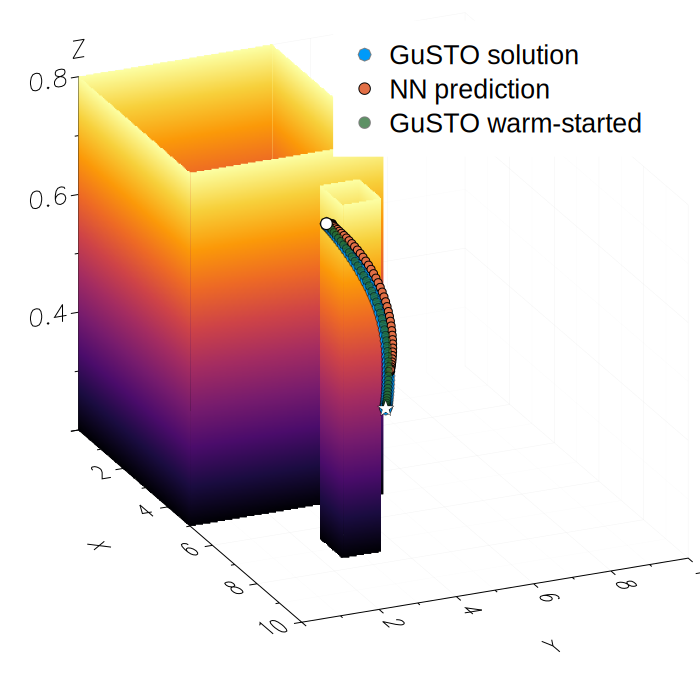

In [108]:
using PyPlot
plot()
# annotate!([(0,0,"hi")])
plot_three_comp_3D_pyplot(model, [X_all_true[end], X_soln_NN, X_all_warm[end]])

plot!(camera=(60,50))
# plot!(legendfontsize = 12, fg_legend = :transparent)
plot!(legendfontsize = 18, fg_legend=:transparent, tickfontsize = 16, guidefontsize = 16, legend=:best,xrotation = 0, yrotation = 0, zrotation=0, rotation=0)
plot!(gridalpha = 0.2)
# plot!(ytickrotation = 90)
yaxis!(rotation = 90)
# annotate!([(0,0,0, text("\$x_{init}\$", 22, :black, :left))])

In [95]:
png("3Dalmostperfect")

In [264]:
png("3DForAlmostPerfectCase")

# Try to add an obstacle to GuSTO now

In [105]:
# Solve with one extra obstacle

x_start= [0.5, 6.125, 0.5]
x_goal = [9., 2.75, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO original solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_init, U_all_init = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN original prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time


# Add an extra obstacle
poly_obstacles = []
obs = PolygonalObstacle([6.0,4.0,0.5], [0.5, 1.0, 2.0])
push!(model.poly_obstacles, obs)


# GuSTO solution time and trajectory- COLD START
time_start = time_ns()
model, isConverged, numIter, X_all_new_cold, U_all_new_cold = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# GuSTO start solution time and trajectory- WARM START
time_start = time_ns()
model, isConverged, numIter_warm, X_all_new_warm, U_all_new_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

GuSTO solve time = 4.541965574 (8 iterations)
NN_solve_time = 0.003088306
GuSTO solve time = 38.964229393 (53 iterations)
GuSTO warm started solve time = 4.793618689 (7 iterations)


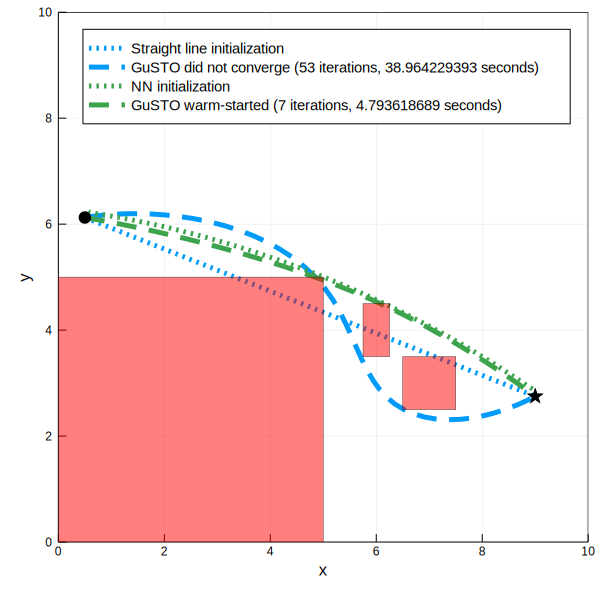

In [109]:
labls = ["Straight line initialization", "GuSTO did not converge ($numIter iterations, $gusto_solve_time seconds)", "NN initialization", "GuSTO warm-started ($numIter_warm iterations, $gusto_warm_solve_time seconds)"]
X_straight = hcat(range(x_init, stop=x_final, length=50)...)
plot_custom(model, [X_straight, X_all_new_cold[end], X_soln_NN,   X_all_new_warm[end]], labls)
plot!(size=(600,600),legend=:best,legendfontsize = 10)
xlabel!("x")
ylabel!("y")

In [ ]:
png("gustoadaptswithwarm")

In [108]:
function plot_custom(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
        idx = [1,2]
    local fig
    fig = plot(framestyle = :box)
    
    
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1                 
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dot), lab = labls[iter], color = 1)
        elseif iter == 2
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 1)
        elseif iter ==3
            plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dot), lab = labls[iter], color = 3)
        elseif iter ==4
            r = plot!(fig, X[idx[1],:], X[idx[2],:];line=(5, :dash), lab = labls[iter], color = 3)
#             @show r.color
#         else
#             plot!(fig, X[idx[1],:], X[idx[2],:];line=(6, :dashdot), linealpha = 0.7, lab = labls[iter], color = 3)
        end        
    end
    
    st_pt = X_all[1][idx[1]:idx[2],1]
    scatter!([st_pt[1]], [st_pt[2]], shape = :circle, markersize = 6, color = :black, lab = "")
    end_pt = X_all[1][idx[1]:idx[2],end]
    scatter!([end_pt[1]], [end_pt[2]], shape = :star, markersize = 8, color = :black, lab = "")
#     annotate!([(st_pt[1]-0.2, st_pt[2]+0.4, text("Start", 12, :black, :left)), 
#             (end_pt[1]+0.3, end_pt[2]-0.4, text("Goal", 12, :black, :right))])


    for obs_i = 1:length(model.obstacles)
        p_obs, obs_radius = model.obstacles[obs_i][1], model.obstacles[obs_i][2]
        plot_circle(p_obs[idx], obs_radius,lab =""; color=:red, fig=fig)
    end
    
    for obs_i = 1:length(model.poly_obstacles)
        center =  model.poly_obstacles[obs_i].c
        (c1,c2) = center[idx]
        if idx[1] == 1
            r1 = model.poly_obstacles[obs_i].dx
        elseif idx[1] == 2
            r1 = model.poly_obstacles[obs_i].dy
        else
            r1 = model.poly_obstacles[obs_i].dz
        end
        if idx[2] == 1
            r2 = model.poly_obstacles[obs_i].dx
        elseif idx[2] == 2
            r2 = model.poly_obstacles[obs_i].dy
        else
            r2 = model.poly_obstacles[obs_i].dz
        end
        lab = ""
        color = :red
        plot!(Shape([(c1-r1,c2-r2), (c1-r1,c2+r2), (c1+r1,c2+r2), (c1+r1, c2-r2)]), seriestype = [:shape,], lw = 0.5,
                c = color, linecolor = :black, linealpha = 0.7,
                fillalpha = 0.5, aspect_ratio = 1, label = lab)
    end
    xlims!((model.x_min[idx[1]],model.x_max[idx[1]]))
    ylims!((model.x_min[idx[2]],model.x_max[idx[2]]))
    plot!(leg =  :bottomright)
    return fig
end

plot_custom (generic function with 7 methods)

In [ ]:
x_start= [1.375, 8., 0.5]
x_goal = [5.5, 4.4375, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
x_start= [0.9375, 8., 0.5]
x_goal = [7.5, 2.1875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
x_start= [2.0, 6., 0.5]
x_goal = [9.0, 2.1875, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("NN helped you avoid both obstacles")

In [ ]:
plot_three_comp_3D(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legendfontsize = 12, fg_legend = :transparent)

In [ ]:
x_start= [2.0, 6., 0.5]
x_goal = [8.0, 1.75, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyComboParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyComboWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPredictionCombo(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legend = :best)

In [ ]:
png("NN speedup and switches homotopy class")

In [ ]:
x_start= [5.55555556, 1.11111111, 0.5]
x_goal = [7.77777778, 6.66666667, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
plot_three_comp_3D(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legendfontsize = 12, fg_legend = :transparent)

In [ ]:
x_start= [0.0, 7.0, 0.5]
x_goal = [8.0, 7.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [0.0, 7.0, 0.5]
x_goal = [6.0, 2.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
function plot_three_comp_3D_custom(model, X_all, labls = :None, time1="", iter1="", time2 ="", time3="", iter3="")
    N = length(X_all)
    labls = ["", "", ""]
    idx = [1,2]
    local fig
#     fig = plot()
    fig = plot(framestyle = :box)
    


    for obs_i = 1
        (c1,c2,c3)  =  model.poly_obstacles[obs_i].c
        dx = model.poly_obstacles[obs_i].dx
        dy = model.poly_obstacles[obs_i].dy
        dz = model.poly_obstacles[obs_i].dz
        
        xmin = c1 - dx
        xmax = c1 + dx
        ymin = c2 - dy
        ymax = c2 + dy
        zmin = c3 - dz
        zmax = c3 + dz
        zmin = 0.2
        zmax = 0.8

        a = (zmax-zmin)/0.002
        b = zmax-0.003*a

        # top and bottom surfaces
        x = range(xmin, stop = xmax, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        f(x,y) = zmax
        g(x,y) = zmin
        plot!(x,y,f, seriestype = :surface, fillalpha = 1.0)
        plot!(x,y,g, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        

        dx = range(xmin + 0.001, stop = xmin + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        h(x,y) = a*(x-xmin) +b
        plot!(dx,y,h, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymax + 0.001, stop = ymax + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        m(x,y) = a*(y-ymax)+b
        plot!(x,dy,m, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        
        dx = range(xmax + 0.001, stop = xmax + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        k(x,y) = a*(x-xmax) +b
        plot!(dx,y,k, seriestype = :surface, fillalpha = 1.0)

        
    end
    
    for obs_i = 2
        (c1,c2,c3)  =  model.poly_obstacles[obs_i].c
        dx = model.poly_obstacles[obs_i].dx
        dy = model.poly_obstacles[obs_i].dy
        dz = model.poly_obstacles[obs_i].dz
        
        xmin = c1 - dx
        xmax = c1 + dx
        ymin = c2 - dy
        ymax = c2 + dy
        zmin = c3 - dz
        zmax = c3 + dz
        zmin = 0.2
        zmax = 0.8

        a = (zmax-zmin)/0.002
        b = zmax-0.003*a

        # top and bottom surfaces
        x = range(xmin, stop = xmax, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        f(x,y) = zmax
        g(x,y) = zmin
        plot!(x,y,f, seriestype = :surface, fillalpha = 1.0)
        plot!(x,y,g, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        

        dx = range(xmin + 0.001, stop = xmin + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        h(x,y) = a*(x-xmin) +b
        plot!(dx,y,h, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymax + 0.001, stop = ymax + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        m(x,y) = a*(y-ymax)+b
        plot!(x,dy,m, seriestype = :surface, fillalpha = 1.0)
        
        dy = range(ymin + 0.001, stop = ymin + 0.003, length = 10)
        x = range(xmin, stop = xmax, length = 10)
        l(x,y) = a*(y-ymin)+b
        plot!(x,dy,l, seriestype = :surface, fillalpha = 1.0)
        
        dx = range(xmax + 0.001, stop = xmax + 0.003, length = 10)
        y = range(ymin, stop = ymax, length = 10)
        k(x,y) = a*(x-xmax) +b
        plot!(dx,y,k, seriestype = :surface, fillalpha = 1.0)

        
    end
    
    for iter = 1:length(X_all)
        X = X_all[iter]
        if iter == 1
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 6, markershape = :octagon,  markerstrokealpha = 0.5, lab = labls[iter], color = iter )
        elseif iter ==2 
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 4, lab = labls[iter], color = iter )
        else
            plot!(X[1,:],X[2,:], X[3,:], seriestype=:scatter, markersize = 4, markeralpha=0.5,  markerstrokealpha = 0.5, lab = labls[iter], color = iter )
        end       
    end
    
    st_pt = X_all[1][:,1]
    scatter!([st_pt[1]], [st_pt[2]],[st_pt[3]], shape = :circle, markersize = 6, color = :white, lab = "Start point")
    end_pt = X_all[1][:,end]
    scatter!([end_pt[1]], [end_pt[2]],[end_pt[3]], shape = :star, markersize = 8, color = :white, lab = "Goal point")

    xlims!((model.x_min[1],model.x_max[1]))
    ylims!((model.x_min[2],model.x_max[2]))
    plot!(zlim = (model.x_min[3]+0.3,model.x_max[3]-0.2), zaxis = "Z")
    plot!(leg =  :best, legfontsize = 10)
    xlabel!("X")
    ylabel!("Y")
    plot!(camera=(120,30), colorbar = :false)
    plot!(size=(700,700,700))
    return fig
end

In [ ]:
plot_three_comp_3D_custom(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], [], round(gusto_solve_time, digits = 2), numIter, round(NN_solve_time, digits = 3), round(gusto_warm_solve_time, digits = 2), numIter_warm)
plot!(legendfontsize = 12, legend = :top)

In [ ]:
png("3DVizTraj")

In [ ]:
x_start= [0.0, 7.0, 0.5]
x_goal = [2.0, 8.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:bottomright)

In [ ]:
x_start= [4.0, 8.0, 0.5]
x_goal = [8.0, 8.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [4.0, 8.0, 0.5]
x_goal = [9.0, 3.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [4.0, 8.0, 0.5]
x_goal = [8.0, 1.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [5.0, 7.0, 0.5]
x_goal = [8.0, 1.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [3.0, 6.0, 0.5]
x_goal = [6.0, 1.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 1.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 0.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 0.3, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
# Warm starting ONLY the X trajectory
x_start= [3.0, 6.0, 0.5]
x_goal = [7.0, 0.3, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, [])
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [3.0, 6.0, 0.5]
x_goal = [9.0, 2.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
# Warm starting ONLY the x trajectory
x_start= [3.0, 6.0, 0.5]
x_goal = [9.0, 2.0, 0.5]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithTwoPolyObsOneAtCorner()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "PolyAstrobeeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "PolyAstrobeeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, [])
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])
plot!(legend=:best)

In [ ]:
x_start= [3.0, 8.0, 0.0]
x_goal = [8.0, 3.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeLargeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "SimpleAstrobeeLargeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [0.0, 9.0, 0.0]
x_goal = [8.0, 3.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeLargeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "SimpleAstrobeeLargeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


In [ ]:
x_start= [0.0, 7.0, 0.0]
x_goal = [8.0, 10.0, 0.0]
x_init = [x_start[1];x_start[2];x_start[3]; 0;0;0;  0.;0.;0.; 1.;  0;0;0]
x_final = [x_goal[1];x_goal[2];x_goal[3]; 0;0;0;  0.;0.;1.0; 0.;  0;0;0]
model = getModelWithCornerSpheres()

# GuSTO solution time and trajectory
time_start = time_ns()
model, isConverged, numIter, X_all_true, U_all_true = findTrueGuSTOSolution(x_init, x_final, model)
gusto_solve_time = (time_ns() - time_start)/10^9
println("GuSTO solve time = $gusto_solve_time ($numIter iterations)")

# NN prediction time and trajectory
paramsFileName = "SimpleAstrobeeLargeParams.h5"
jsonFileName = "SimpleAstrobeeTemplate.json"
weightsFileName = "SimpleAstrobeeLargeWeights.h5"
time_start = time_ns()
X_soln_NN , U_soln_NN = getNNPrediction(x_init, x_final, paramsFileName, jsonFileName, weightsFileName)
NN_solve_time = (time_ns() - time_start)/10^9
@show NN_solve_time

# GuSTO warm start solution time and trajectory
time_start = time_ns()
model, isConverged, numIter_warm, X_all_warm, U_all_warm  = findTrueGuSTOSolution(x_init, x_final, model, false, X_soln_NN, U_soln_NN)
gusto_warm_solve_time = (time_ns() - time_start)/10^9
println("GuSTO warm started solve time = $gusto_warm_solve_time ($numIter_warm iterations)")

plot_three_comp(model, [X_all_true[end], X_soln_NN, X_all_warm[end]], ["True GuSTO solution", "NN prediction", "GuSTO solution warm-started with NN prediction"])


# Not implemented yet

In [ ]:
function carryOutSequence(runs, NNDualParams = nothing, NNDualJSON = nothing, NNDualWeights = nothing)
    println("----------")
    model = getModelWithCornerSpheres()
    

    
#     gusto_setup_time = (time_ns() - time_start)/10^9

#     times = []
    
#     time_start = time_ns()
    # Set up NN if required
    if !(NNDualParams == nothing || NNDualJSON == nothing || NNDualWeights == nothing)
        xMin, yMin, xRange, yRange = getDataParamsFromHDF5(NNDualParams)
        NN = Keras.load(NNDualJSON, NNDualWeights)
    end
    NN_setup_time = (time_ns() - time_start)/10^9
    
    
    # Set up shooting problem
    N = 20
    SP = ShootingProblem(TOP, TOSgusto.SCPS)
    TOSgusto.SS = ShootingSolution(SP, deepcopy(traj_init))
    SS = TOSgusto.SS
    
    println("GuSTO setup time is $gusto_setup_time")
    println("NN setup time is $NN_setup_time")
    
    while length(runs)>0
        run = popfirst!(runs)
        if startswith(run,"GuSTO-")
            num_iter = parse(Int64, run[7:end])
            println("Doing $num_iter iteration(s) of GuSTO")
            traj = Trajectory(traj_X_vec[end], traj_U_vec[end], tf)
            # Set dual to the end of dual_vec
            if !isdefined(TOSgusto, :SCPS)
                println("defining SCPS")
                SCPP = SCPProblem(TOP)
                SCPS = SCPSolution(SCPP, traj)
                TOSgusto.traj, TOSgusto.SCPS = SCPS.traj, SCPS
            end
            TOSgusto.traj = traj
            TOSgusto.SCPS.dual = dual_vec[end]
            solve_gusto_jump!(TOSgusto.SCPS, TOSgusto.SCPS.SCPP, "Ipopt", max_iter=num_iter, print_level=1)

#             solve_SCP!(TOSgusto, TOP, solve_gusto_jump!, traj, "Ipopt", max_iter=num_iter, print_level=1);
            iter_times = TOSgusto.SCPS.iter_elapsed_times
            @show iter_times
            @show TOSgusto.SCPS.J_true
            num_actual_iter = (length(iter_times)>num_iter+1) ? num_iter : length(iter_times)-1
            append!(times, iter_times[end-(num_actual_iter-1):end])
            push!(dual_vec, TOSgusto.SCPS.dual)
            push!(traj_X_vec, TOSgusto.SCPS.traj.X)
            push!(traj_U_vec, TOSgusto.SCPS.traj.U)
            if (TOSgusto.SCPS.converged)
                println("GuSTO converged!")
                println("Cost reported: $(TOSgusto.SCPS.J_true)")
            end
        elseif startswith(run,"NNDual-")
            num_iter = parse(Int64, run[8:end])
            if (NNDualParams == nothing || NNDualJSON == nothing || NNDualWeights == nothing)
                println("Error: one or more of the NN duals filenames is missing")
            else
                println("Doing $num_iter iteration(s) of NN- dual")
                if isdefined(TOSgusto, :SCPS) && isdefined(TOSgusto.SCPS, :param) && isdefined(TOSgusto.SCPS.param, :alg)
                    ω = TOSgusto.SCPS.param.alg.ω_vec[end]
                    Δ = TOSgusto.SCPS.param.alg.Δ_vec[end]
                else 
                    ω = ω0
                    Δ = Δ0
                end
                NN_input = createNNInput(traj_X_vec[end], traj_U_vec[end], ω, Δ, xMin, xRange, dual_vec[end])
                NN_inter = NN_input
                for i=1:num_iter
                    time_start = time_ns()
                    
                    NN_output = NN(NN_inter)
                    output_dual = recoverDualfromNNOutput(NN_output, yMin, yRange)
                    
                    iter_elapsed_time = (time_ns() - time_start)/10^9
                    push!(times, iter_elapsed_time)
                    
                    push!(dual_vec, output_dual)
                    
                    # Just repeating the same trajectories
                    push!(traj_X_vec, traj_X_vec[end])
                    push!(traj_U_vec, traj_U_vec[end])
                    
                    # output dual is input for next iteration of NN
                    NN_inter = vcat(NN_input[1:182], output_dual)
                end
            end
        elseif startswith(run, "Shooting")
            TOSgusto.SS.SP.p0 = dual_vec[end]
            solve!(TOSgusto.SS, TOSgusto.SS.SP)
            push!(times, TOSgusto.SS.iter_elapsed_times[end])
            if TOSgusto.SS.prob_status[end]== Symbol(:Optimal)
                println("Shooting method converged!")
                println("Costs reported: $(TOSgusto.SS.J_true)")
            else
                println("Shooting method did not converge.")
            end
        else
            println("Error: $run is not a supported command. Make sure to append the number of iterations at the end of a command.")
        end
    end
    @show times
    # @show dual_vec
    println("----------")
    return (dual_vec, traj_X_vec, traj_U_vec, times)
end